In [ ]:
pip install omadb  pandas seaborn numpy scipy pyham SPARQLWrapper networkx

In [93]:
from io import StringIO
import pandas as pd
import numpy as np

#lets pull in the tor pathway members with some gene names
def unirequest_tab(name):
    #we query first by protein name and then gene name
    url = 'http://rest.uniprot.org/uniprotkb/stream?'
    params = [
    'query=(protein_name:{})%20AND%20(organism_id:9606)'.format(name),
    'fields=id,gene_names,protein_name,reviewed,protein_name,organism_name,xref_bgee',
    'format=tsv',
    ]
    params = ''.join([ p+'&' for p in params ])[:-1]
    print(url+params)
    data = requests.get(url+params).text
    #only return the first hit for each query
    try:
        data =  pd.read_table(StringIO(data)).iloc[0]
        data['short_name'] = name
        return data    
    except IndexError:
        
        try:
            url = 'http://rest.uniprot.org/uniprotkb/stream?'
            params = [
            'query=(gene:{})%20AND%20(organism_id:9606)'.format(name),
            'fields=id,gene_names,protein_name,reviewed,protein_name,organism_name,xref_bgee',
            'format=tsv',
            ]
            params = ''.join([ p+'&' for p in params ])[:-1]
            print(url+params)
            data = requests.get(url+params).text
            data =  pd.read_table(StringIO(data)).iloc[0]
            data['short_name'] = name
            return data

        except:
            print('no hits', name)


names = ['mtor' , 'irs', 'p13k' , 'bdnf' , 'ndmar' , 'mglur' , 'tsc1', 'tsc2' , 'akt' , 'rheb', 'raptor' 
         , 'lst8' , 'pras40', 's6k', 'ef2k' , '4ebp' , 'erk' ,'pdk1' , 'protor' , 'sin1'  , 'rictor']
name_results = pd.concat([unirequest_tab(name) for name in names] , axis = 1 , ignore_index= True).transpose()
name_results['pathway']= 'TOR'
print(name_results)

http://rest.uniprot.org/uniprotkb/stream?query=(protein_name:mtor)%20AND%20(organism_id:9606)&fields=id,gene_names,protein_name,reviewed,protein_name,organism_name,xref_bgee&format=tsv
http://rest.uniprot.org/uniprotkb/stream?query=(protein_name:irs)%20AND%20(organism_id:9606)&fields=id,gene_names,protein_name,reviewed,protein_name,organism_name,xref_bgee&format=tsv
http://rest.uniprot.org/uniprotkb/stream?query=(protein_name:p13k)%20AND%20(organism_id:9606)&fields=id,gene_names,protein_name,reviewed,protein_name,organism_name,xref_bgee&format=tsv
http://rest.uniprot.org/uniprotkb/stream?query=(gene:p13k)%20AND%20(organism_id:9606)&fields=id,gene_names,protein_name,reviewed,protein_name,organism_name,xref_bgee&format=tsv
no hits p13k
http://rest.uniprot.org/uniprotkb/stream?query=(protein_name:bdnf)%20AND%20(organism_id:9606)&fields=id,gene_names,protein_name,reviewed,protein_name,organism_name,xref_bgee&format=tsv
http://rest.uniprot.org/uniprotkb/stream?query=(protein_name:ndmar)%20A

In [94]:
#Obtain a list of genes from uniprot.
#we restrained the search to human genes 

import json
import requests

def unirequest_tab_go(GOterm):
    url = 'http://rest.uniprot.org/uniprotkb/stream?'
    params = [
    'query=(organism_id:9606)%20AND%20(go:{})'.format(GOterm),
    'fields=id,gene_names,protein_name,reviewed,protein_name,organism_name,xref_bgee',
    'format=tsv',
    ]
    params = ''.join([ p+'&' for p in params ])[:-1]
    print(url+params)
    data = requests.get(url+params).text
    
    return data
#here we pull in our proteins of interest for each biological process
terms = ['0030509' ]
pathways = ['BMP']
datasets = { t:unirequest_tab_go(t) for t in terms}

http://rest.uniprot.org/uniprotkb/stream?query=(organism_id:9606)%20AND%20(go:0030509)&fields=id,gene_names,protein_name,reviewed,protein_name,organism_name,xref_bgee&format=tsv


In [95]:


#Load queries into some dataframes

queries =[]
for i,term in enumerate(datasets):
    df = pd.read_table(StringIO(datasets[term]))
    print(df.head())
    df['pathway'] = pathways[i]
    df['protein_name'] = df['Protein names'].map( lambda x : x.split(',')[0])

    df = df[df.Reviewed != 'unreviewed']
    df['short_name'] = df['Gene Names'].map( lambda x : x.split(' ')[0])
    #let's subsample to a few entries for the sake of brevity 
    df = df.sample(n = 15)
    print(df.head())
    queries.append(df)

#Total starting dataset
queries = pd.concat(queries+[name_results])
#in this line we iterate through the dataframe to generate a dictionary of names we will use to identify our proteins at each step of our analysis.
names= { query['Entry Name']:query['short_name'] + ' '+query.pathway for index,query in queries[['Entry Name','short_name','pathway']].iterrows() if query['short_name'] is not np.nan }

         Entry Name       Gene Names  \
0  A0A024R274_HUMAN  SMAD4 hCG_23686   
1  A0A024R8E2_HUMAN   ABL1 hCG_28416   
2  A0A0S2Z310_HUMAN           ACVRL1   
3  A0A140VJU3_HUMAN              NaN   
4  A0A384N611_HUMAN              NaN   

                                       Protein names    Reviewed  \
0  Mothers against decapentaplegic homolog, MAD h...  unreviewed   
1               Tyrosine-protein kinase, EC 2.7.10.2  unreviewed   
2  Serine/threonine-protein kinase receptor, EC 2...  unreviewed   
3                   Testicular tissue protein Li 170  unreviewed   
4                                        Protein Wnt  unreviewed   

                                     Protein names.1              Organism  \
0  Mothers against decapentaplegic homolog, MAD h...  Homo sapiens (Human)   
1               Tyrosine-protein kinase, EC 2.7.10.2  Homo sapiens (Human)   
2  Serine/threonine-protein kinase receptor, EC 2...  Homo sapiens (Human)   
3                   Testicular tissue 

In [96]:
queries

Entry Name                          Gene Names  \
52   ACVR1_HUMAN                       ACVR1 ACVRLK2   
24    BMP2_HUMAN                          BMP2 BMP2A   
37    GDF1_HUMAN                                GDF1   
50   TGBR3_HUMAN                              TGFBR3   
49   PO5F1_HUMAN               POU5F1 OCT3 OCT4 OTF3   
91   SMUF1_HUMAN                     SMURF1 KIAA1625   
20   BMP15_HUMAN                         BMP15 GDF9B   
96    GDF2_HUMAN                           GDF2 BMP9   
74   BMP8A_HUMAN                               BMP8A   
39    MSX2_HUMAN                           MSX2 HOX8   
89   TWSG1_HUMAN                  TWSG1 TSG PSEC0250   
44    GDF5_HUMAN                    GDF5 BMP14 CDMP1   
54   SMAD4_HUMAN                    SMAD4 DPC4 MADH4   
12   USP9Y_HUMAN                         USP9Y DFFRY   
26    ATF2_HUMAN                   ATF2 CREB2 CREBP1   
0    LTOR5_HUMAN                   LAMTOR5 HBXIP XIP   
1     IRS4_HUMAN                                IRS4   
2     BDNF_HUMAN                                BDNF   
3   Q32NF0_HUMAN                                TSC1   
4     TSC2_HUMAN                           TSC2 TSC4   
5    TBCD4_HUMAN               TBC1D4 AS160 KIAA0603   
6     RHEB_HUMAN                          RHEB RHEB2   
7    RPTOR_HUMAN               RPTOR KIAA1303 RAPTOR   
8     LST8_HUMAN                      MLST8 GBL LST8   
9    AKTS1_HUMAN                       AKT1S1 PRAS40   
10   KS6A5_HUMAN                        RPS6KA5 MSK1   
11   MP2K7_HUMAN  MAP2K7 JNKK2 MEK7 MKK7 PRKMK7 SKK4   
12   PDPK1_HUMAN                          PDPK1 PDK1   
13    PRR5_HUMAN                  PRR5 PROTOR1 PP610   
14    SIN1_HUMAN                   MAPKAP1 MIP1 SIN1   
15    PRR5_HUMAN                  PRR5 PROTOR1 PP610   

                                        Protein names    Reviewed  \
52  Activin receptor type-1, EC 2.7.11.30 (Activin...    reviewed   
24  Bone morphogenetic protein 2, BMP-2 (Bone morp...    reviewed   
37   Embryonic growth/differentiation factor 1, GDF-1    reviewed   
50  Transforming growth factor beta receptor type ...    reviewed   
49  POU domain, class 5, transcription factor 1 (O...    reviewed   
91  E3 ubiquitin-protein ligase SMURF1, hSMURF1, E...    reviewed   
20  Bone morphogenetic protein 15, BMP-15 (Growth/...    reviewed   
96  Growth/differentiation factor 2, GDF-2 (Bone m...    reviewed   
74              Bone morphogenetic protein 8A, BMP-8A    reviewed   
39    Homeobox protein MSX-2 (Homeobox protein Hox-8)    reviewed   
89             Twisted gastrulation protein homolog 1    reviewed   
44  Growth/differentiation factor 5, GDF-5 (Bone m...    reviewed   
54  Mothers against decapentaplegic homolog 4, MAD...    reviewed   
12  Probable ubiquitin carboxyl-terminal hydrolase...    reviewed   
26  Cyclic AMP-dependent transcription factor ATF-...    reviewed   
0   Ragulator complex protein LAMTOR5 (Hepatitis B...    reviewed   
1   Insulin receptor substrate 4, IRS-4 (160 kDa p...    reviewed   
2   Brain-derived neurotrophic factor, BDNF (Abrin...    reviewed   
3                                        TSC1 protein  unreviewed   
4              Tuberin (Tuberous sclerosis 2 protein)    reviewed   
5   TBC1 domain family member 4 (Akt substrate of ...    reviewed   
6   GTP-binding protein Rheb (Ras homolog enriched...    reviewed   
7   Regulatory-associated protein of mTOR, Raptor ...    reviewed   
8   Target of rapamycin complex subunit LST8, TORC...    reviewed   
9   Proline-rich AKT1 substrate 1 (40 kDa proline-...    reviewed   
10  Ribosomal protein S6 kinase alpha-5, S6K-alpha...    reviewed   
11  Dual specificity mitogen-activated protein kin...    reviewed   
12  3-phosphoinositide-dependent protein kinase 1,...    reviewed   
13  Proline-rich protein 5 (Protein observed with ...    reviewed   
14  Target of rapamycin complex 2 subunit MAPKAP1,...    reviewed   
15  Proline-rich protein 5 (Protein observed with ...    reviewed   

    

In [97]:
from omadb import Client
c = Client()
omadata = {}
#retrieve oma entries for all query genes
for query in list(queries['Entry Name']) :
    try:
        omadata[query] = c.entries.__getitem__(query) 
    except:
        print('err ' +query)

#Take all queries from human and
#get orthologs in all of the species they're found in
orthologs = {}
for query in omadata:
    orthologs[query] = c.entries.orthologs(omadata[query]['omaid'])

#Create profiles from orthology data, with species codes as columns
#obtain all species codes for query genes
profiles = {}
for query in orthologs:
    profiles[query] = {}
    profiles[query]['short_name'] = names[query]
    for ortho in orthologs[query]:
        spec = ortho['omaid'][0:5]
        if spec not in profiles[query]:
            profiles[query][spec] = 1
        else:
            profiles[query][spec]+=1

#The columns of the matrix are the union of all the species represented across all orthologs
columns = set([ spec  for query in profiles for spec in profiles[query] ])
#Add in 0s where the orthologs are absent
for query in profiles:
    profiles[query].update( { spec : 0 for spec in columns if spec not in profiles[query] } )

#Create a dataframe with this dictionary

orthosdf = pd.DataFrame.from_dict( profiles , orient = 'index')
orthosdf.index = orthosdf.short_name
orthosdf = orthosdf.drop('short_name', axis = 1)


err Q32NF0_HUMAN


In [98]:
orthosdf.head()

NAEGR  BRAFL  PETMA  EPTBU  CALMI  LEPOC  ANGAN  ANATE  SERDU  \
short_name                                                                  
ACVR1 BMP       1      1      1      1      1      1      2      1      2   
BMP2 BMP        0      0      1      0      1      1      2      1      0   
GDF1 BMP        0      0      1      0      1      0      0      1      0   
TGFBR3 BMP      0      1      0      0      1      1      2      1      1   
POU5F1 BMP      0      0      0      0      0      0      0      0      0   

            ECHNA  ...  YEAST  PHLGI  DROPS  ORYNI  SCHJY  RHOGW  KAZNA  \
short_name         ...                                                    
ACVR1 BMP       1  ...      0      0      0      0      0      0      0   
BMP2 BMP        0  ...      0      0      0      0      0      0      0   
GDF1 BMP        0  ...      0      0      0      0      0      0      0   
TGFBR3 BMP      1  ...      0      0      0      0      0      0      0   
POU5F1 BMP      0  ...      0      0      0      0      0      0      0   

            NECHA  ANOGA  SARSC  
short_name                       
ACVR1 BMP       0      0      0  
BMP2 BMP        0      1      0  
GDF1 BMP        0      0      0  
TGFBR3 BMP      0      0      0  
POU5F1 BMP      0      0      0  

[5 rows x 593 columns]

/home/cactuskid/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


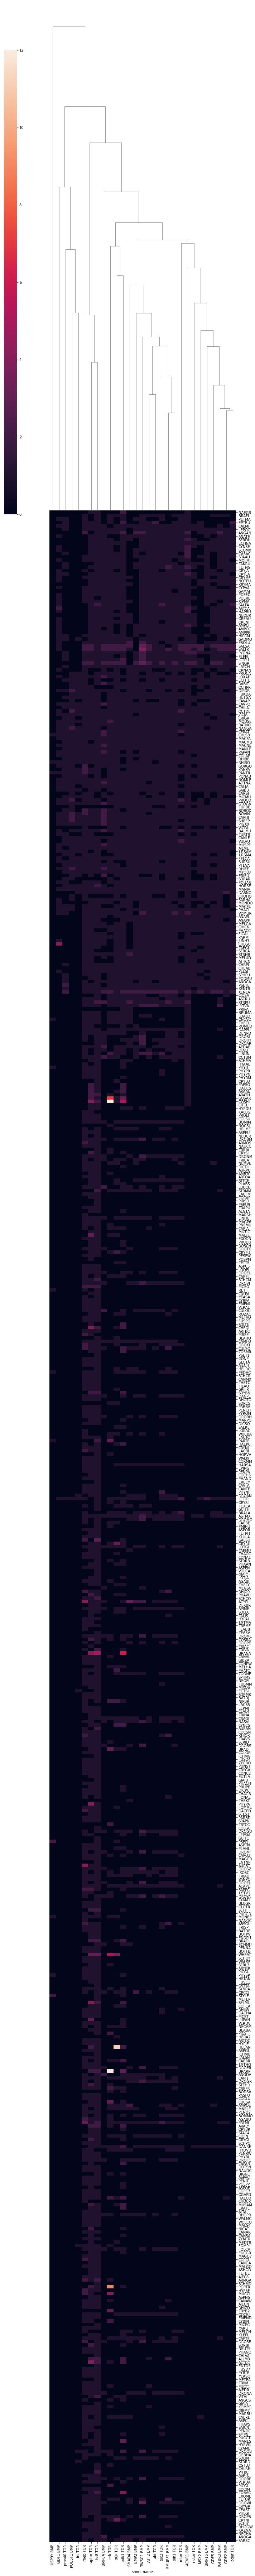

In [99]:
#Use seaborn to visualize the clustering of functional modules

import seaborn as sns
from matplotlib import pyplot as plt

#Metrics used to compare the vectors to establish a distance kernel
metrics = [ 'euclidean', 'hamming', 'jaccard' ]

#Hierarchical clustering methods
methods = [ 'average' , 'weighted' , 'centroid']

#Visualize the clustered profile matrix
sns.clustermap( orthosdf.T , metric= metrics[2] , method=methods[1] , col_cluster=True, row_cluster= False, yticklabels = orthosdf.columns , figsize = (10, 100))


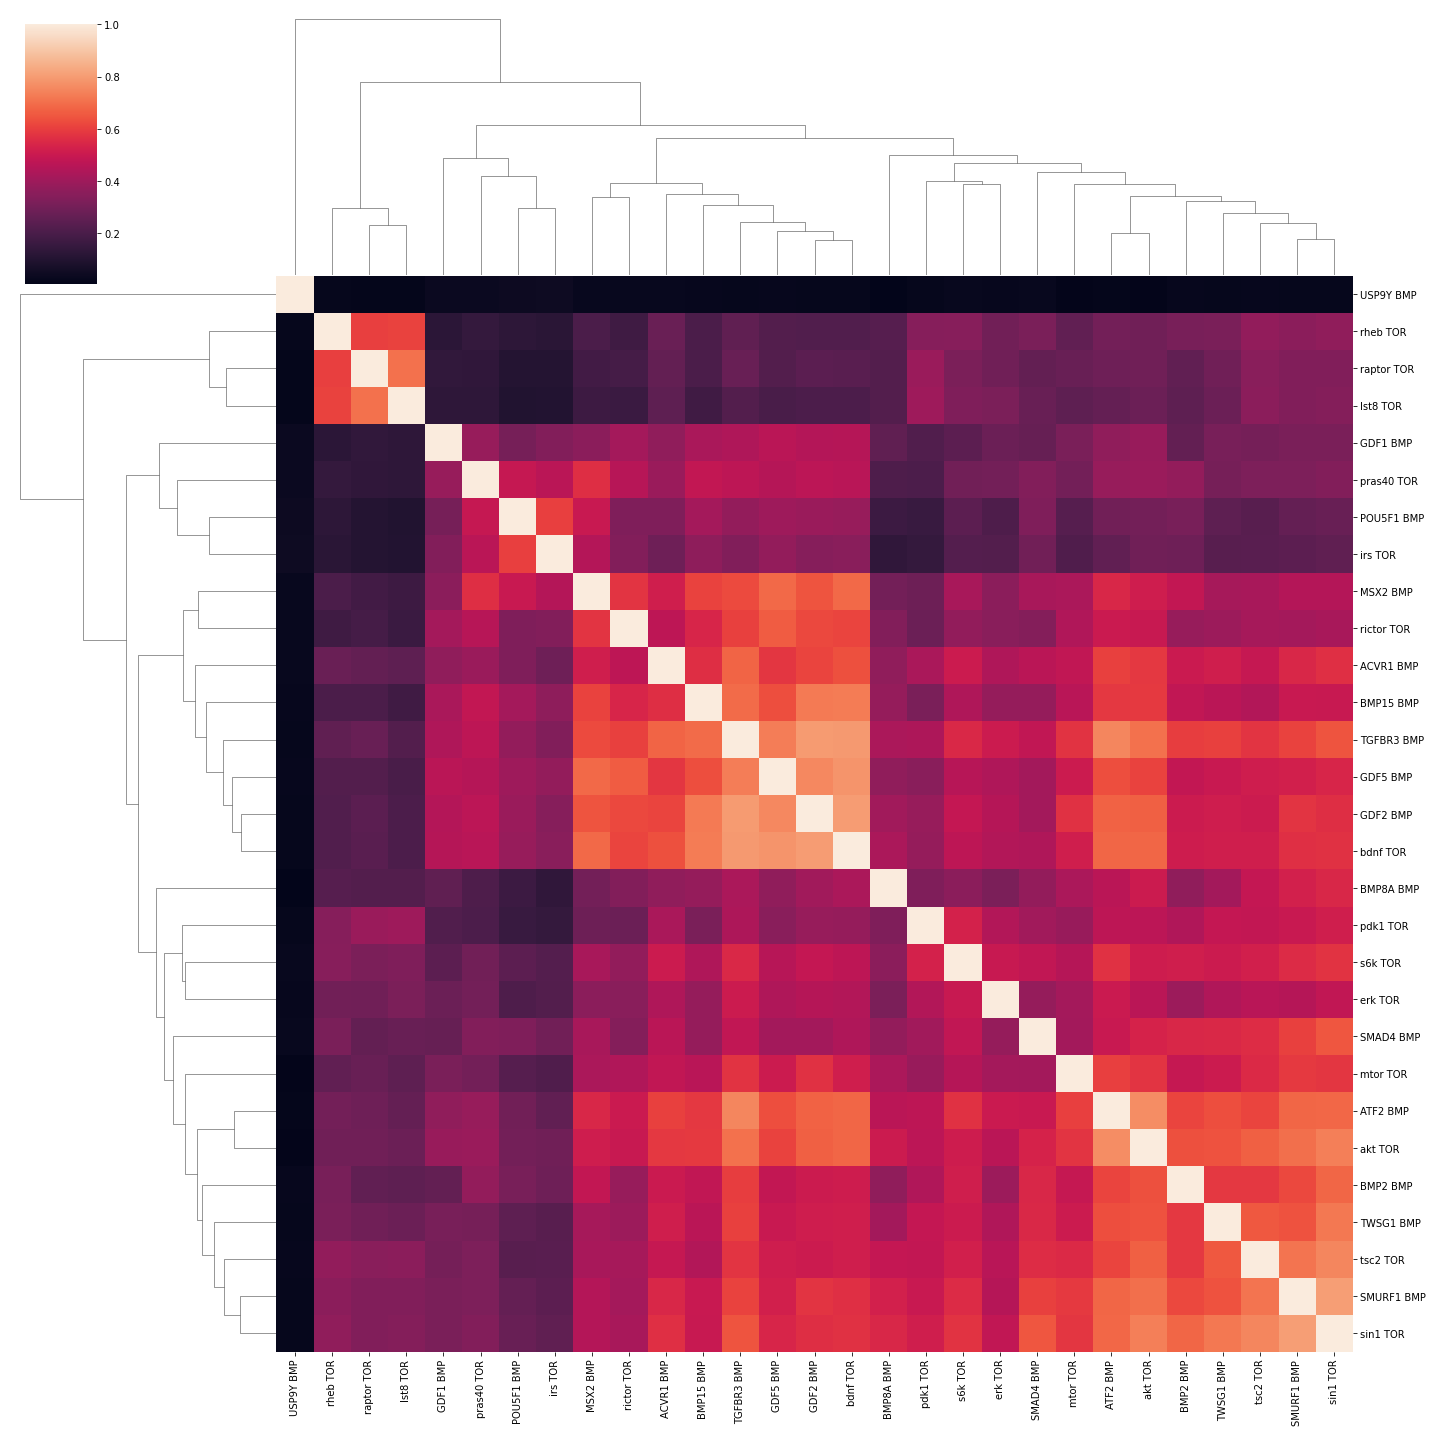

In [100]:
#here we directly establish the distance matrix between all profiles
from scipy.spatial.distance import cdist

#let's generate a distance kernel with a distance metric of our choice
distmat = cdist(orthosdf.to_numpy(), orthosdf.to_numpy() , metric = metrics[2])
sns.clustermap( 1-distmat , metric= metrics[0] , method=methods[1] , col_cluster=True, row_cluster= True, yticklabels = orthosdf.index , xticklabels = orthosdf.index , figsize = (20, 20))


In [101]:
#let's use independent analysis to comfirm 
#we need the BGee cross reference for our genes and some network data from string
queries = queries.dropna()
qlist = { query['Entry Name']:query['Bgee'].replace(';','') for index,query in queries[['Entry Name','Bgee']].iterrows() if query['Bgee'] is not np.nan }
qlists = {'HUMAN': qlist }

# now using some cross references to other organisms
xrefs = {}
#we're going to grab the ensemble IDs for the orthologues from a few species also present in the Bgee dataset
#Bgee species are listed here https://bgee.org
#species information for OMA is available at https://omabrowser.org/All/oma-species.txt
#Ive selected some interesting species that are in both
species = [ 'DROME','CAEEL' , 'DANRE' , 'MOUSE' , 'PIGXX']

#retrieve the uniprot xrefs for each of the sequences
allnames = {}
taxmap = {'HUMAN':9606}
for q in orthologs:
    for o in orthologs[q]:
        for spec in species:
            if spec not in xrefs:
                xrefs[spec] = {}
            
            if  o['omaid'][0:5] == spec:
                if spec not in taxmap:
                    taxmap[spec] = o['species']['taxon_id']
                xrefs[spec][o['omaid'] ] = c.entries.xrefs(o['omaid'])
                if 'UniProtKB/TrEMBL' in xrefs[spec][o['omaid'] ]:
                    names[ xrefs[spec][o['omaid']]['UniProtKB/TrEMBL'][0]] = names[q]
allnames.update(names)

for spec in species:
    #map everything to Bgee/ensembl gene IDs
    qlist = {}
    tryagain = []
    for entry in xrefs[spec]:
        if 'Bgee' in xrefs[spec][entry]  and 'UniProtKB/TrEMBL' in xrefs[spec][entry]:
            try:
                qlist.update({xrefs[spec][entry]['UniProtKB/TrEMBL'][0] : xrefs[spec][entry]['Bgee'][0].split('.')[0] })
            except IndexError:
                pass
        elif 'UniProtKB/TrEMBL' in xrefs[spec][entry]:
            tryagain.append(xrefs[spec][entry]['UniProtKB/TrEMBL'][0])
    print('qlist',qlist)
    print(tryagain)
    qlists[spec] = qlist
    

qlist {'A0A0B4KFU5': 'FBgn0029006', 'P27091': 'FBgn0024234', 'D3PFG0': 'FBgn0003865', 'Q9W494': 'FBgn0000394', 'Q8IMG6': 'FBgn0011655', 'M9PD17': 'FBgn0005198', 'Q9VND8': 'FBgn0041191', 'Q9W437': 'FBgn0029840', 'B4F5L6': 'FBgn0264691', 'M9PH06': 'FBgn0010303', 'Q9W0V1': 'FBgn0020386', 'Q9V719': 'FBgn0033935'}
['A0A0B4KG76']
qlist {'P34443': 'WBGene00010038', 'P91040': 'WBGene00015697', 'A0A2K5ATN2': 'WBGene00008311', 'Q21307': 'WBGene00003185', 'Q9Y1J3': 'WBGene00003965'}
[]
qlist {'O13109': 'ENSDARG00000013409', 'E7FDB6': 'ENSDARG00000099979', 'Q6PCR3': 'ENSDARG00000016086', 'Q58FS4': 'ENSDARG00000037491', 'F1QWZ4': 'ENSDARG00000059173', 'Q1LWW7': 'ENSDARG00000035677', 'A0A0J9YJ71': 'ENSDARG00000104651', 'B2GR89': 'ENSDARG00000104244', 'F1QK08': 'ENSDARG00000002760', 'E9QBP5': 'ENSDARG00000023903', 'E7FA90': 'ENSDARG00000090194', 'F1Q5K0': 'ENSDARG00000018817', 'E9QC96': 'ENSDARG00000075156', 'A0A0R4IPN3': 'ENSDARG00000003167', 'E7FE05': 'ENSDARG00000060551', 'F6P5Q1': 'ENSDARG0000000

In [102]:
#Retrieving tissue specific expression for each of our genes using
#a sparql query for using lists of ensemble IDs on BGEE
from SPARQLWrapper import SPARQLWrapper , CSV
from io import StringIO

endpt = "https://bgee.org/sparql/"
sparql = SPARQLWrapper(endpt)

#here's the template sparql query we're going to be using
#we can add our gene IDs for each species

query = '''

PREFIX orth: <http://purl.org/net/orth#>
PREFIX genex: <http://purl.org/genex#>
PREFIX lscr: <http://purl.org/lscr#>
PREFIX gene: <http://purl.org/net/orth#Gene>
PREFIX obo: <http://purl.obolibrary.org/obo/>
SELECT DISTINCT ?anat ?anatName ?geneEns{{
    
    values  ?geneEns {{   {0}   }}
    ?gene genex:isExpressedIn ?anat .
    ?gene lscr:xrefEnsemblGene ?geneEns.
	?gene rdfs:label ?geneName .
	?anat rdfs:label ?anatName .
}}
'''

dfs = []
for species in qlists:
    print(qlists[species])
    #for each species in our queries
    #make a list of gene IDs
    
    pre = '<http://rdf.ebi.ac.uk/resource/ensembl/'
    suf = '>'
    ensemblelist = ''.join( [ pre + qlists[species][uniID]  + suf + ' ' for uniID in qlists[species] ] )
    #get the Bgee data
    print(ensemblelist)
    sparql.setQuery(query.format(ensemblelist))
    sparql.setReturnFormat(CSV)
    results = sparql.query().convert()
    #and make a dataframe for our returned results
    sub = pd.read_csv(StringIO(results.decode()) )
    #add which species the data came from to our dataframe columns
    sub['species'] = species
    sub['geneEns'] = sub['geneEns'].map(lambda x : x.split('/')[-1])
    
    #add the uniprot cannonical IDs into our dataframe as well
    sub['canonicalid'] = sub['geneEns'].map(dict(zip( qlists[species].values(), qlists[species].keys() )))
    #use uniprot IDs to map back to our original human gene names 
    sub['names'] =  sub['canonicalid'].map(names)
    dfs.append(sub)


#put everything into one big dataframe
expressionDF = pd.concat(dfs)


{'ACVR1_HUMAN': 'ENSG00000115170', 'BMP2_HUMAN': 'ENSG00000125845', 'GDF1_HUMAN': 'ENSG00000130283', 'TGBR3_HUMAN': 'ENSG00000069702', 'PO5F1_HUMAN': 'ENSG00000204531', 'SMUF1_HUMAN': 'ENSG00000198742', 'BMP15_HUMAN': 'ENSG00000130385', 'GDF2_HUMAN': 'ENSG00000263761', 'BMP8A_HUMAN': 'ENSG00000183682', 'MSX2_HUMAN': 'ENSG00000120149', 'TWSG1_HUMAN': 'ENSG00000128791', 'GDF5_HUMAN': 'ENSG00000125965', 'SMAD4_HUMAN': 'ENSG00000141646', 'USP9Y_HUMAN': 'ENSG00000114374', 'ATF2_HUMAN': 'ENSG00000115966'}
<http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000115170> <http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000125845> <http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000130283> <http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000069702> <http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000204531> <http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000198742> <http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000130385> <http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000263761> <http://rdf.ebi.ac.uk/resource/ensembl/ENSG0000

HUMAN
                                            anat             anatName  \
0      http://purl.obolibrary.org/obo/CL_0000655     secondary oocyte   
1  http://purl.obolibrary.org/obo/UBERON_0000002       uterine cervix   
2  http://purl.obolibrary.org/obo/UBERON_0000004                 nose   
3  http://purl.obolibrary.org/obo/UBERON_0000006  islet of Langerhans   
4  http://purl.obolibrary.org/obo/UBERON_0000007      pituitary gland   

           geneEns species  canonicalid       names  
0  ENSG00000069702   HUMAN  TGBR3_HUMAN  TGFBR3 BMP  
1  ENSG00000069702   HUMAN  TGBR3_HUMAN  TGFBR3 BMP  
2  ENSG00000069702   HUMAN  TGBR3_HUMAN  TGFBR3 BMP  
3  ENSG00000069702   HUMAN  TGBR3_HUMAN  TGFBR3 BMP  
4  ENSG00000069702   HUMAN  TGBR3_HUMAN  TGFBR3 BMP  


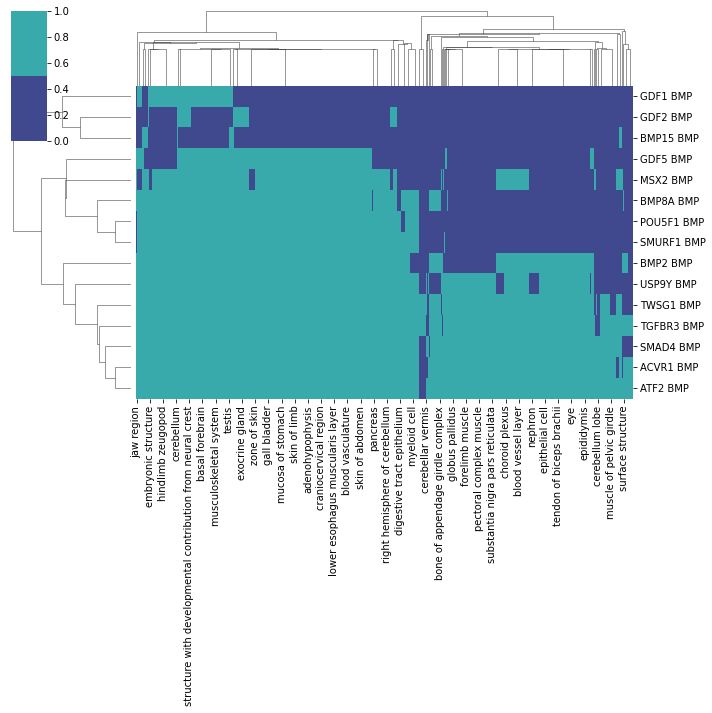

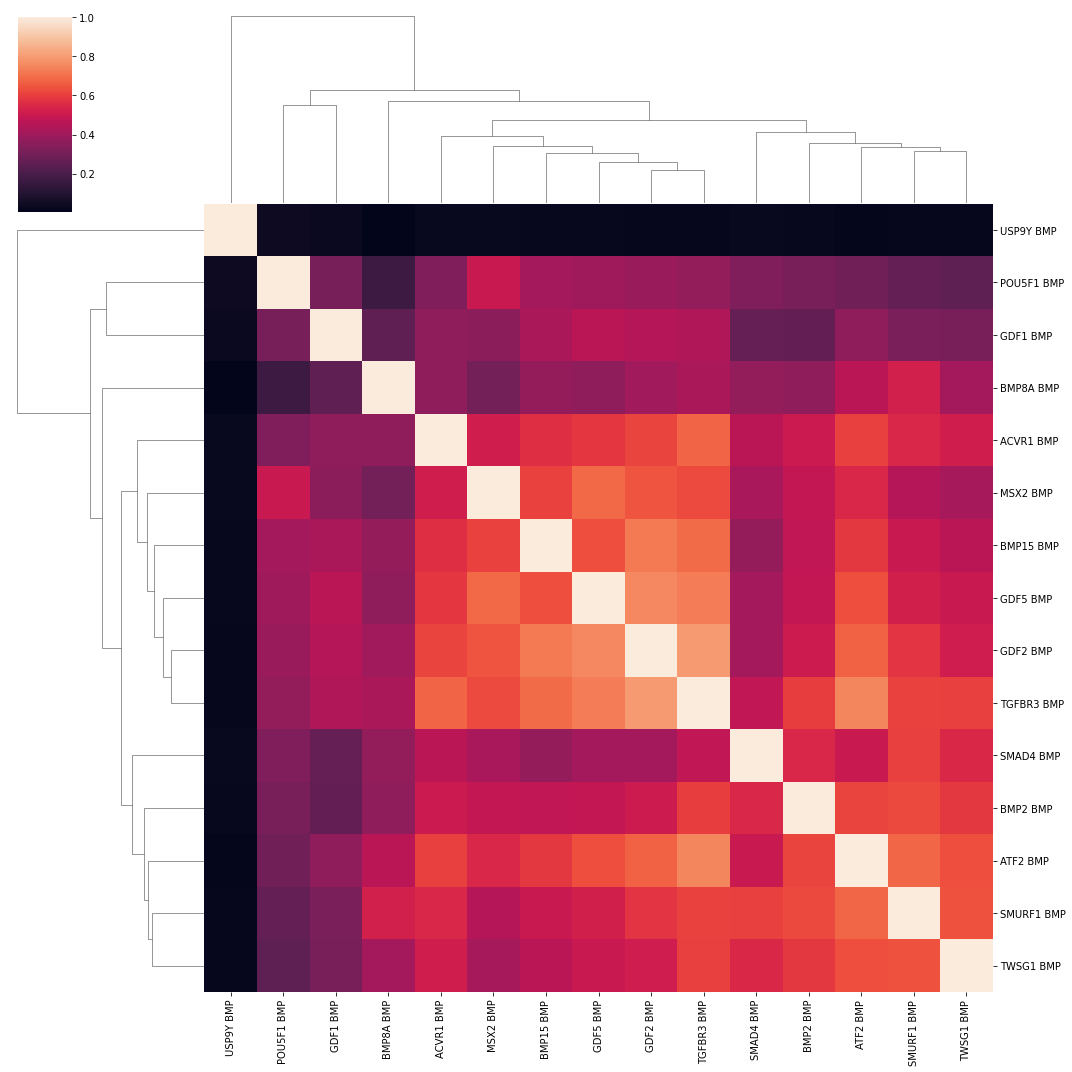

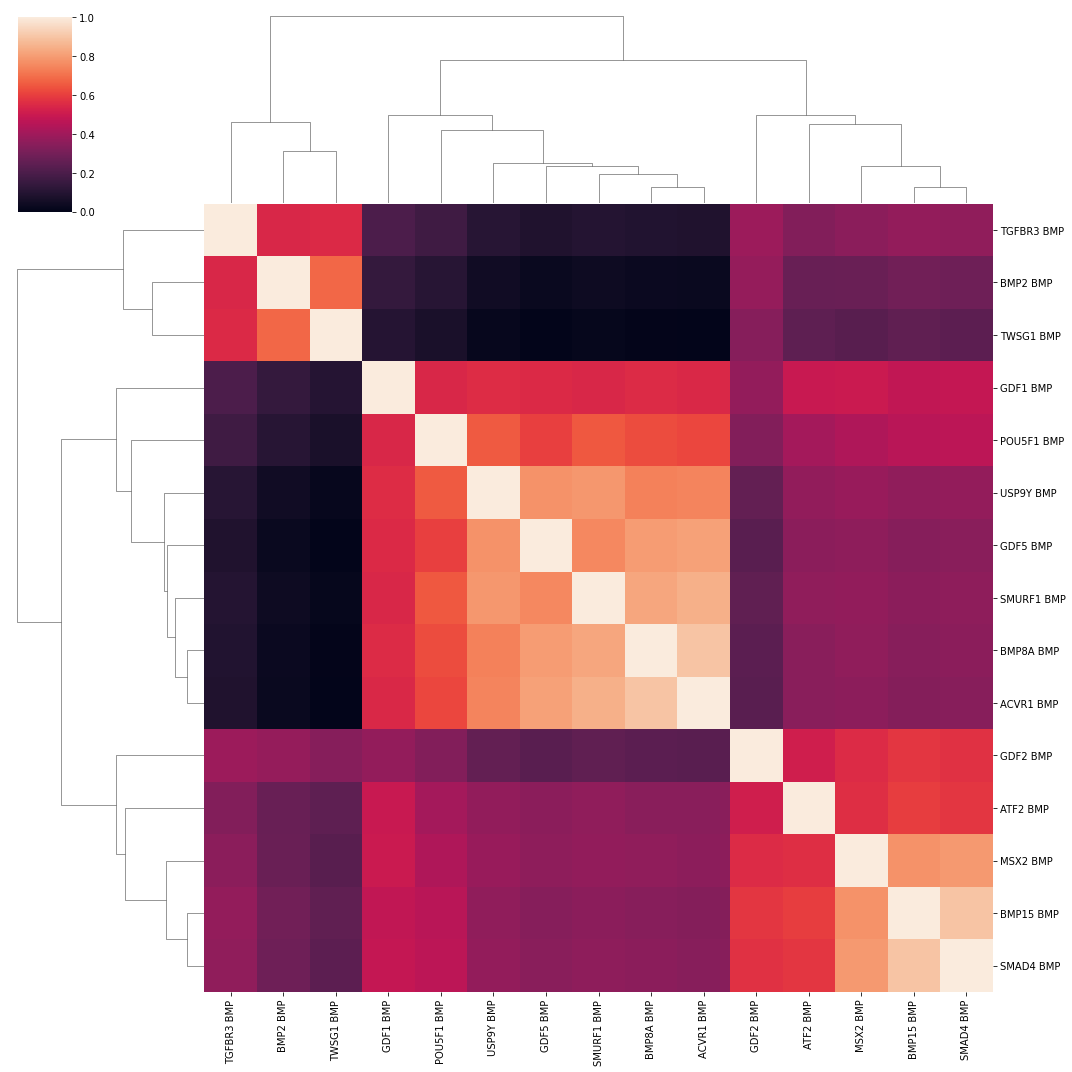

 do our matrices match from one approach to the other? 


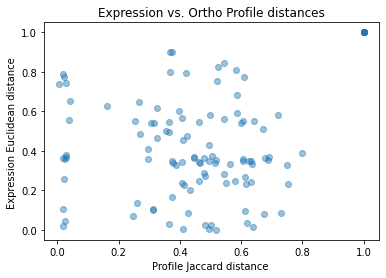

Pearson:PearsonRResult(statistic=0.24789847934546597, pvalue=0.00017225698721469595)
DROME
                                            anat          anatName  \
0      http://purl.obolibrary.org/obo/CL_0000655  secondary oocyte   
1  http://purl.obolibrary.org/obo/UBERON_0000033              head   
2  http://purl.obolibrary.org/obo/UBERON_0000323       late embryo   
3  http://purl.obolibrary.org/obo/UBERON_0000473            testis   
4  http://purl.obolibrary.org/obo/UBERON_0000922            embryo   

       geneEns species canonicalid      names  
0  FBgn0000394   DROME      Q9W494  TWSG1 BMP  
1  FBgn0000394   DROME      Q9W494  TWSG1 BMP  
2  FBgn0000394   DROME      Q9W494  TWSG1 BMP  
3  FBgn0000394   DROME      Q9W494  TWSG1 BMP  
4  FBgn0000394   DROME      Q9W494  TWSG1 BMP  


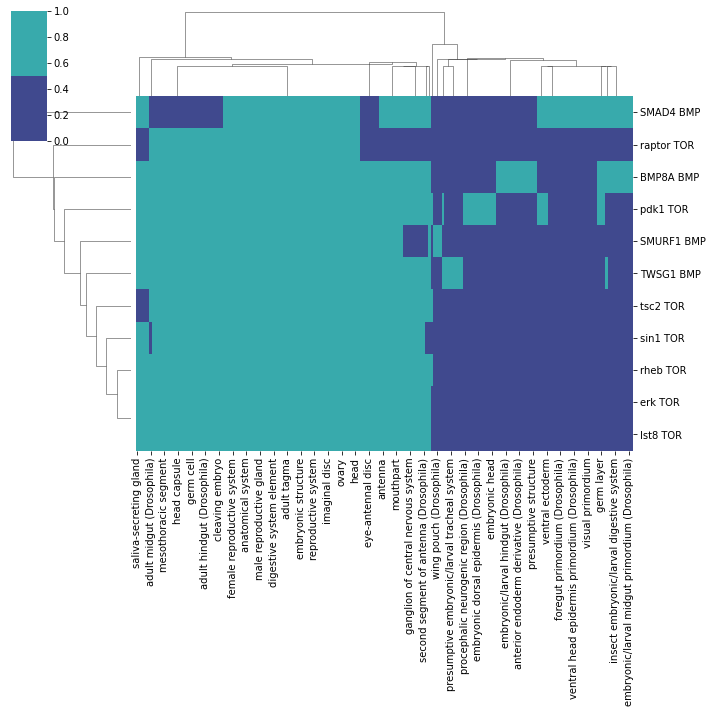

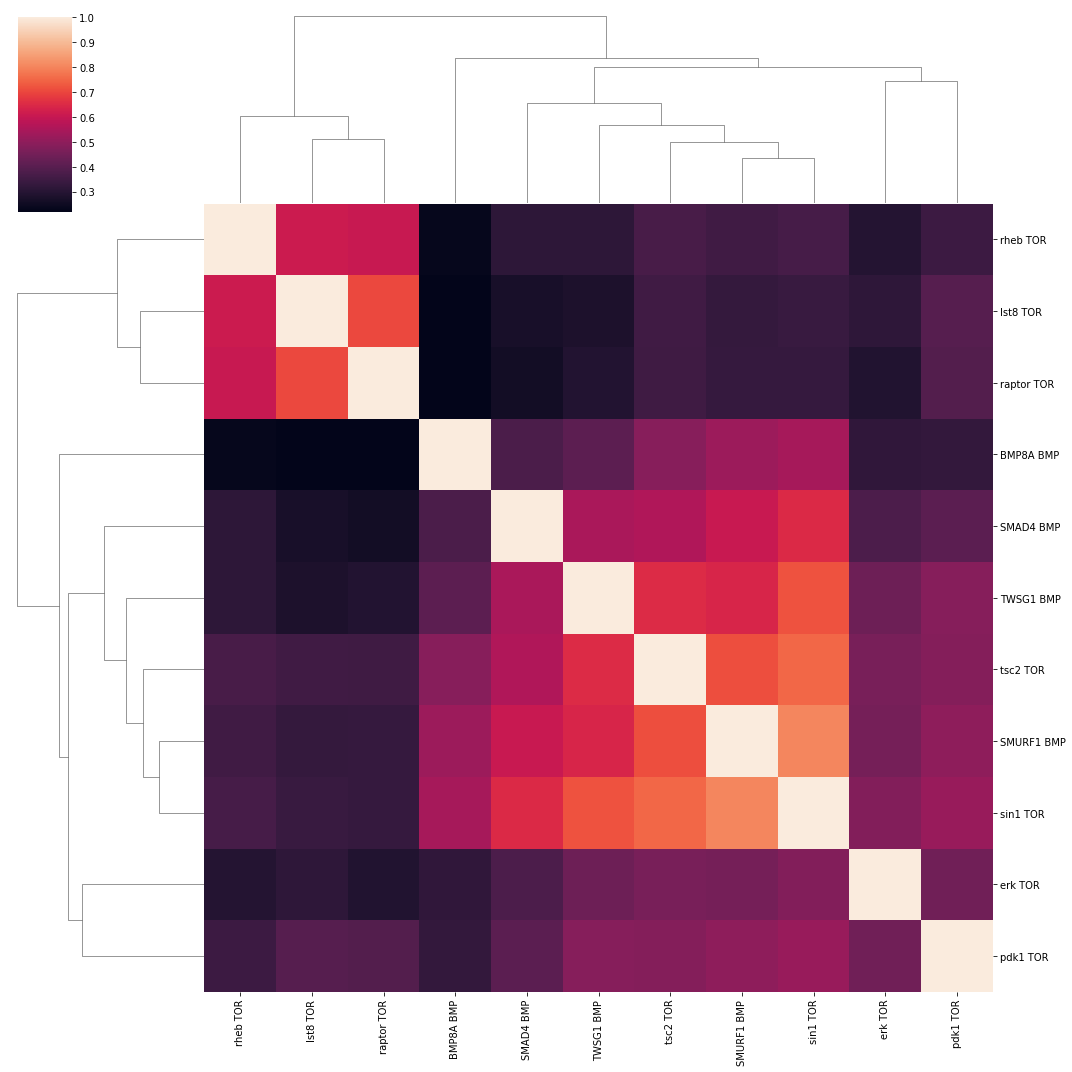

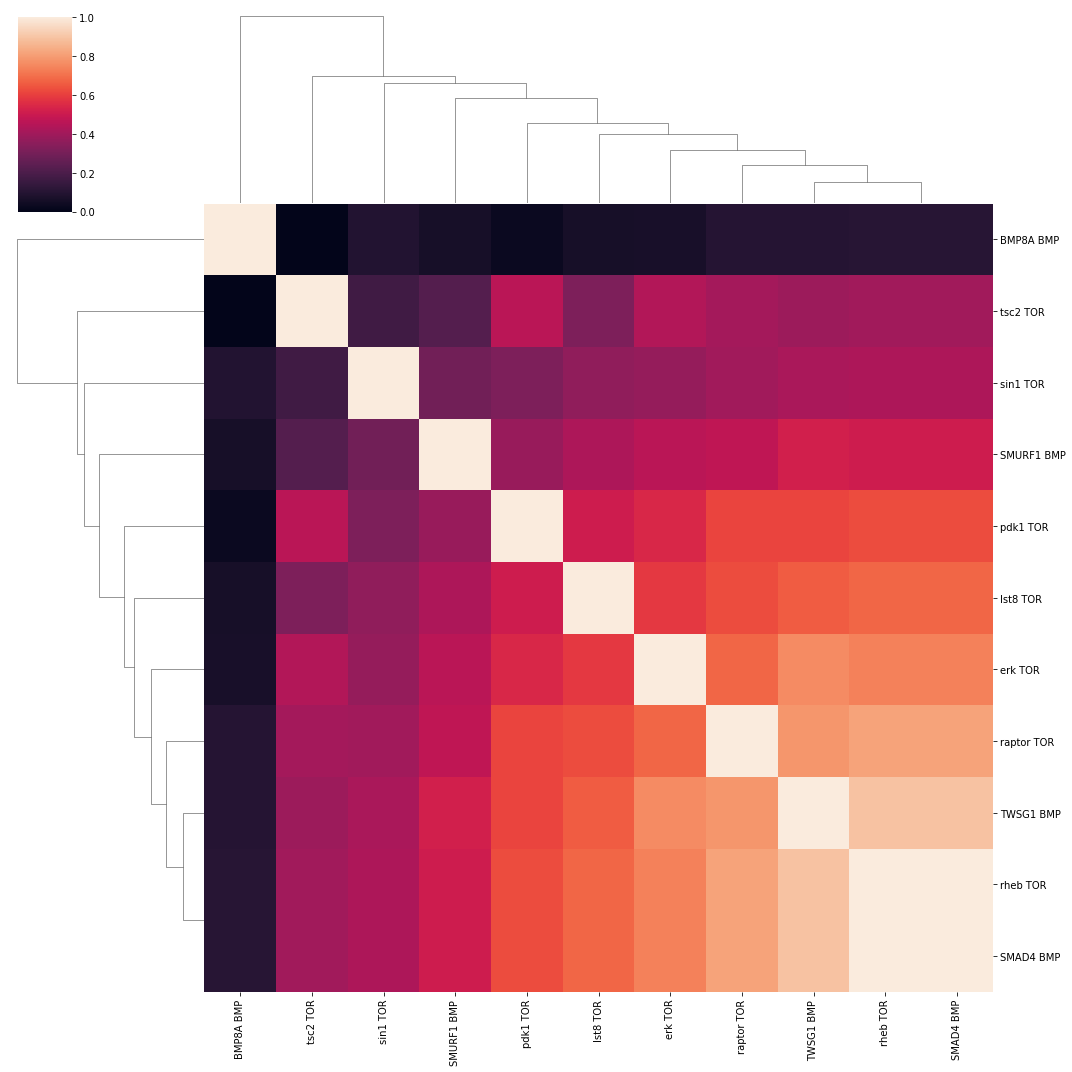

 do our matrices match from one approach to the other? 


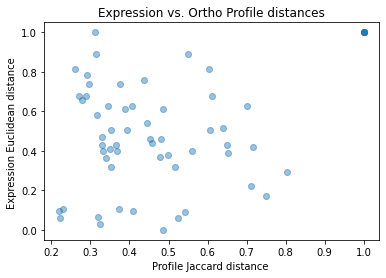

Pearson:PearsonRResult(statistic=0.36606765668952973, pvalue=3.6400523653358845e-05)
CAEEL
                                            anat anatName         geneEns  \
0  http://purl.obolibrary.org/obo/UBERON_0000922   embryo  WBGene00003185   
1  http://purl.obolibrary.org/obo/UBERON_0000922   embryo  WBGene00003965   
2  http://purl.obolibrary.org/obo/UBERON_0000922   embryo  WBGene00008311   
3  http://purl.obolibrary.org/obo/UBERON_0000922   embryo  WBGene00010038   
4  http://purl.obolibrary.org/obo/UBERON_0000922   embryo  WBGene00015697   

  species canonicalid     names  
0   CAEEL      Q21307   erk TOR  
1   CAEEL      Q9Y1J3  pdk1 TOR  
2   CAEEL  A0A2K5ATN2   s6k TOR  
3   CAEEL      P34443  rheb TOR  
4   CAEEL      P91040  lst8 TOR  


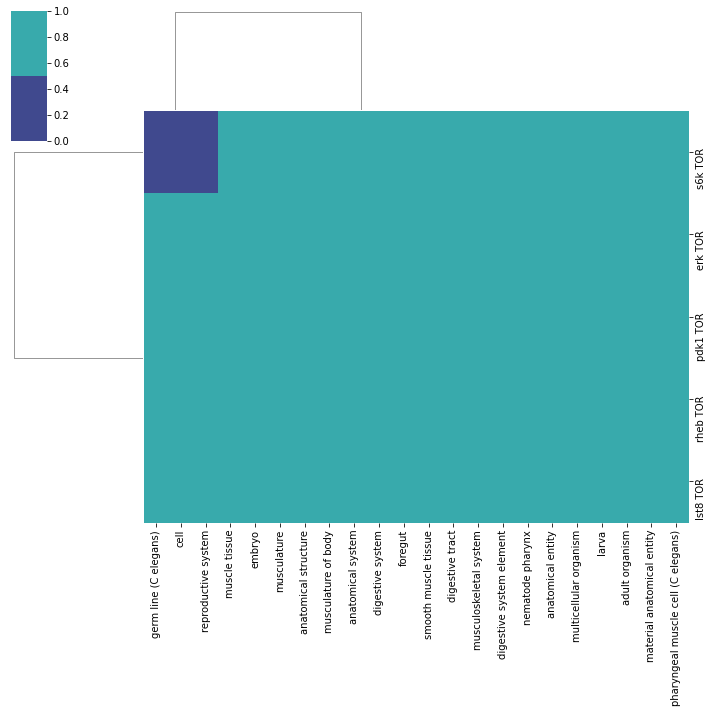

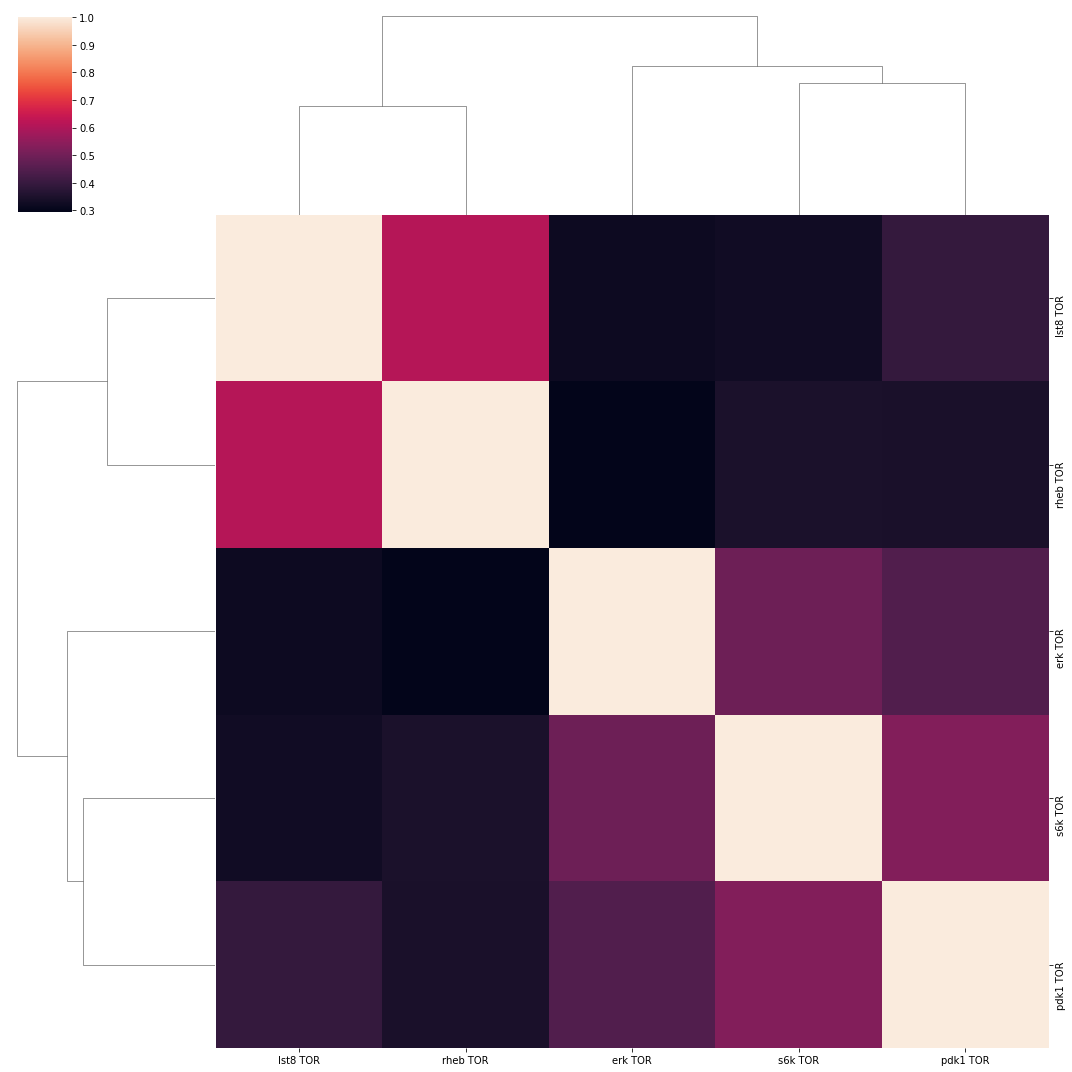

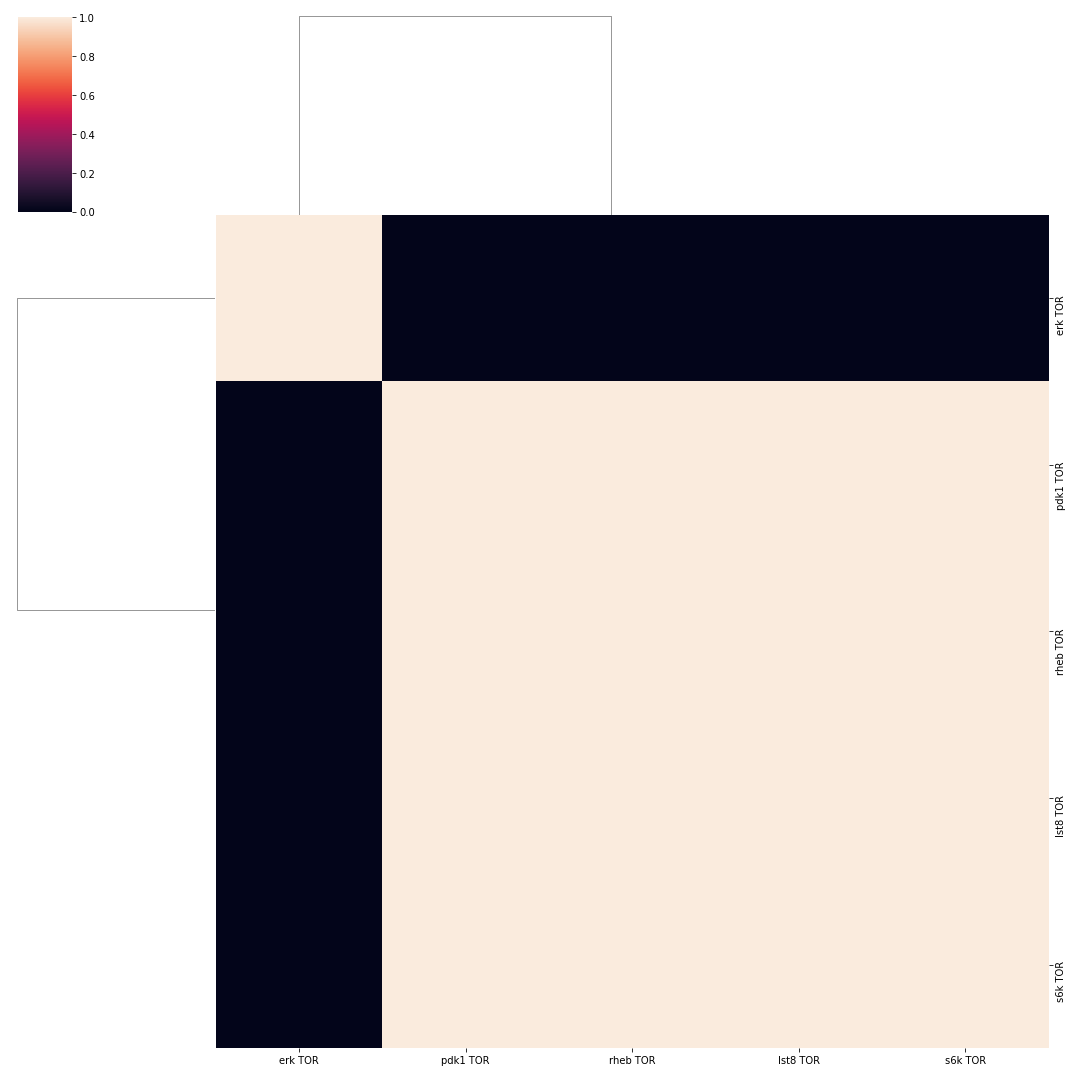

 do our matrices match from one approach to the other? 


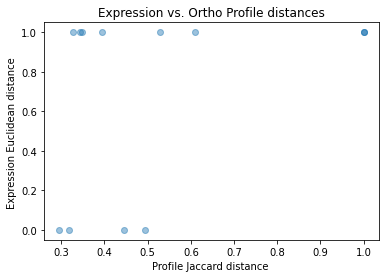

Pearson:PearsonRResult(statistic=0.3821072402018681, pvalue=0.059433928435509424)
DANRE
                                            anat                   anatName  \
0  http://purl.obolibrary.org/obo/UBERON_0000004                       nose   
1  http://purl.obolibrary.org/obo/UBERON_0000007            pituitary gland   
2  http://purl.obolibrary.org/obo/UBERON_0000010  peripheral nervous system   
3  http://purl.obolibrary.org/obo/UBERON_0000019            camera-type eye   
4  http://purl.obolibrary.org/obo/UBERON_0000033                       head   

              geneEns species canonicalid     names  
0  ENSDARG00000018817   DANRE      F1Q5K0  bdnf TOR  
1  ENSDARG00000018817   DANRE      F1Q5K0  bdnf TOR  
2  ENSDARG00000018817   DANRE      F1Q5K0  bdnf TOR  
3  ENSDARG00000018817   DANRE      F1Q5K0  bdnf TOR  
4  ENSDARG00000002760   DANRE      F1QK08  GDF5 BMP  


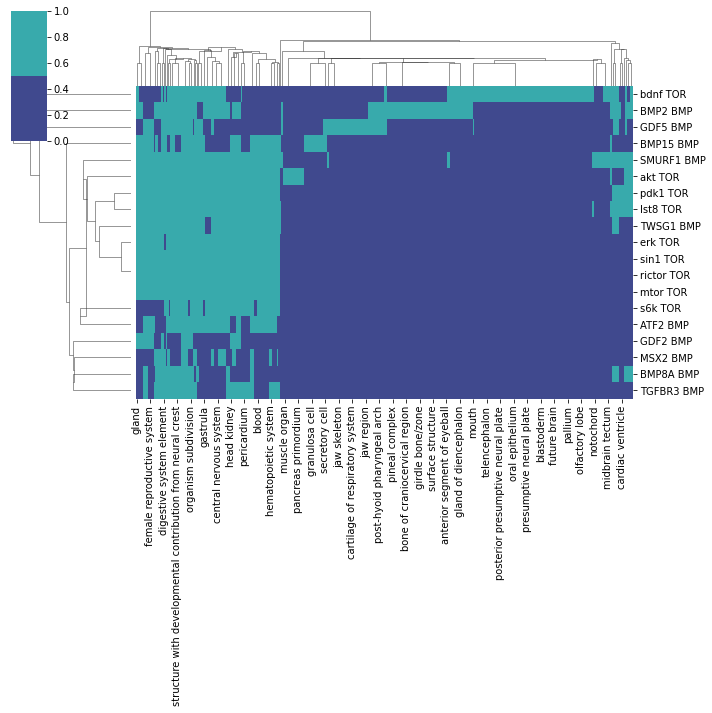

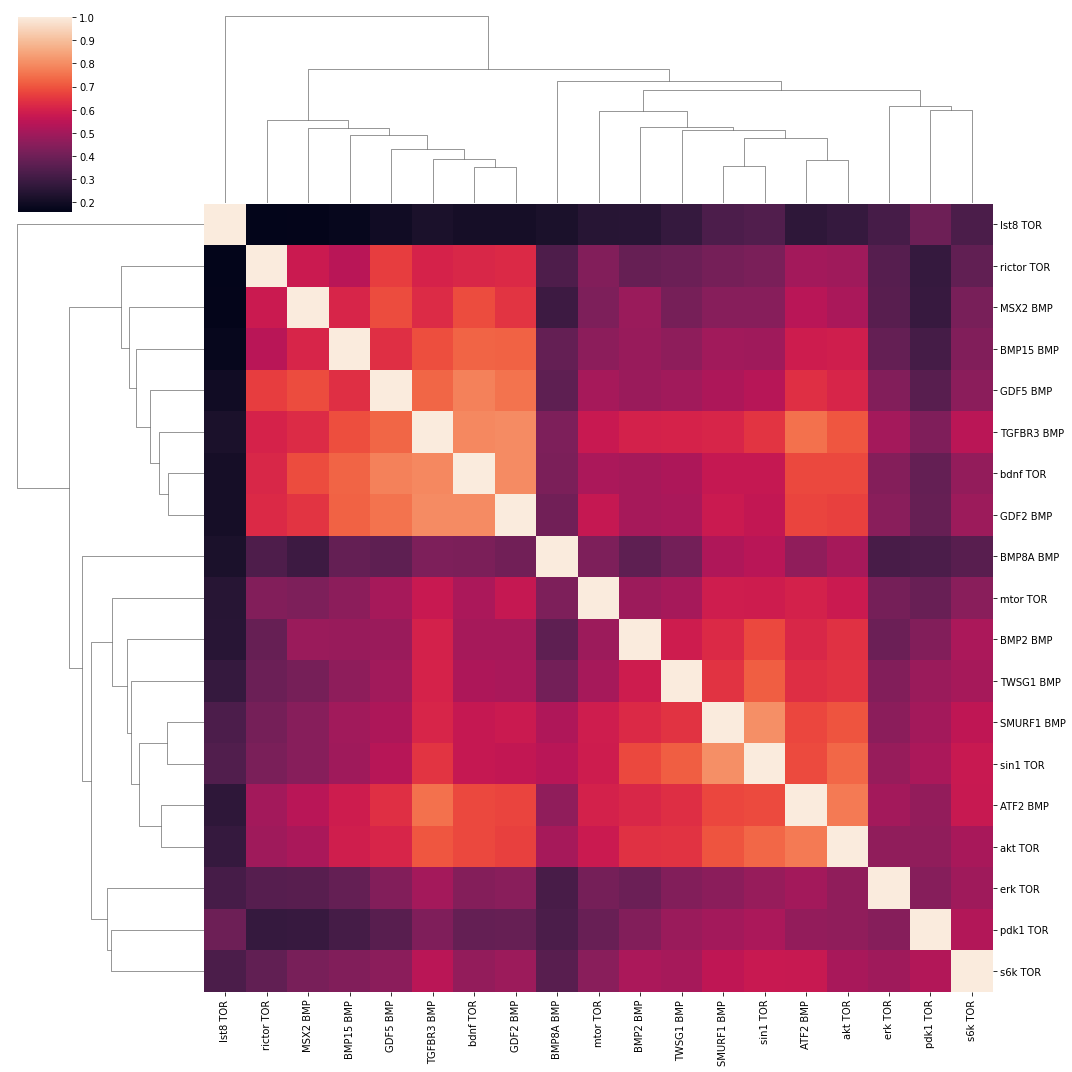

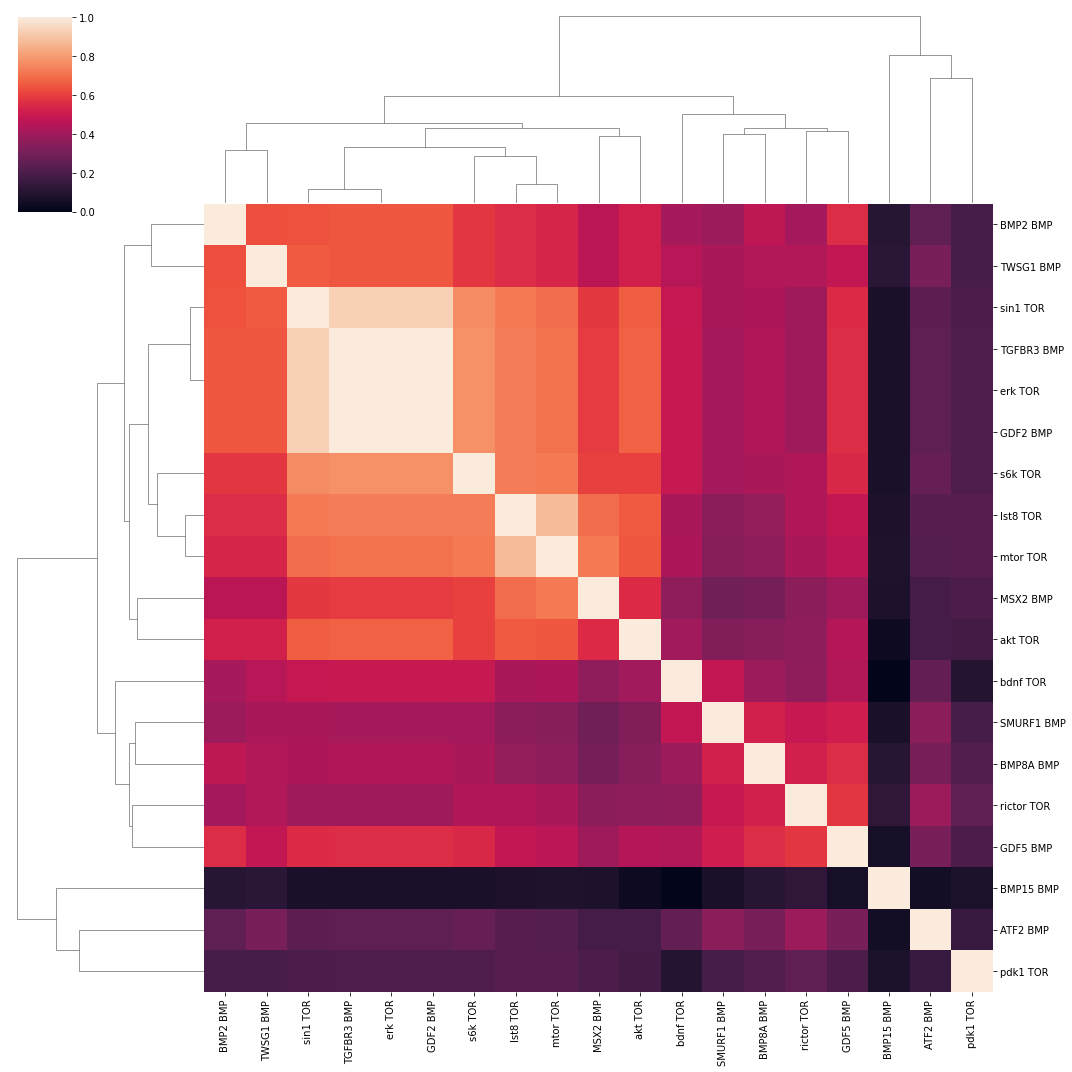

 do our matrices match from one approach to the other? 


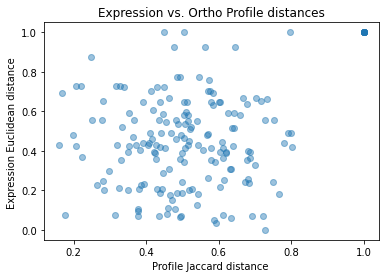

Pearson:PearsonRResult(statistic=0.3078797994987424, pvalue=2.2982772929198832e-09)
MOUSE
                                        anat          anatName  \
0  http://purl.obolibrary.org/obo/CL_0000365     animal zygote   
1  http://purl.obolibrary.org/obo/CL_0000510       paneth cell   
2  http://purl.obolibrary.org/obo/CL_0000654    primary oocyte   
3  http://purl.obolibrary.org/obo/CL_0000655  secondary oocyte   
4  http://purl.obolibrary.org/obo/CL_0000711      cumulus cell   

              geneEns species canonicalid      names  
0  ENSMUSG00000024098   MOUSE      Q9EP52  TWSG1 BMP  
1  ENSMUSG00000024098   MOUSE      Q9EP52  TWSG1 BMP  
2  ENSMUSG00000024098   MOUSE      Q9EP52  TWSG1 BMP  
3  ENSMUSG00000024098   MOUSE      Q9EP52  TWSG1 BMP  
4  ENSMUSG00000024098   MOUSE      Q9EP52  TWSG1 BMP  


/home/cactuskid/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


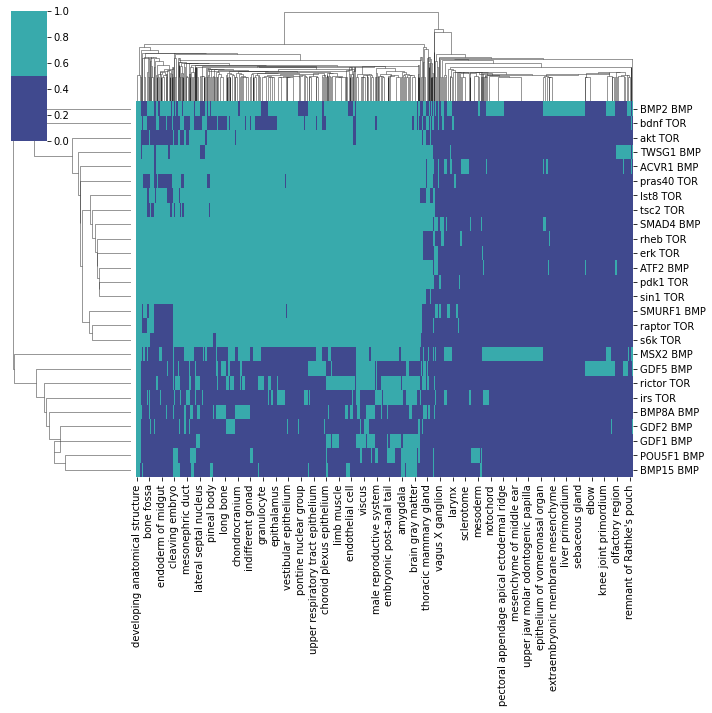

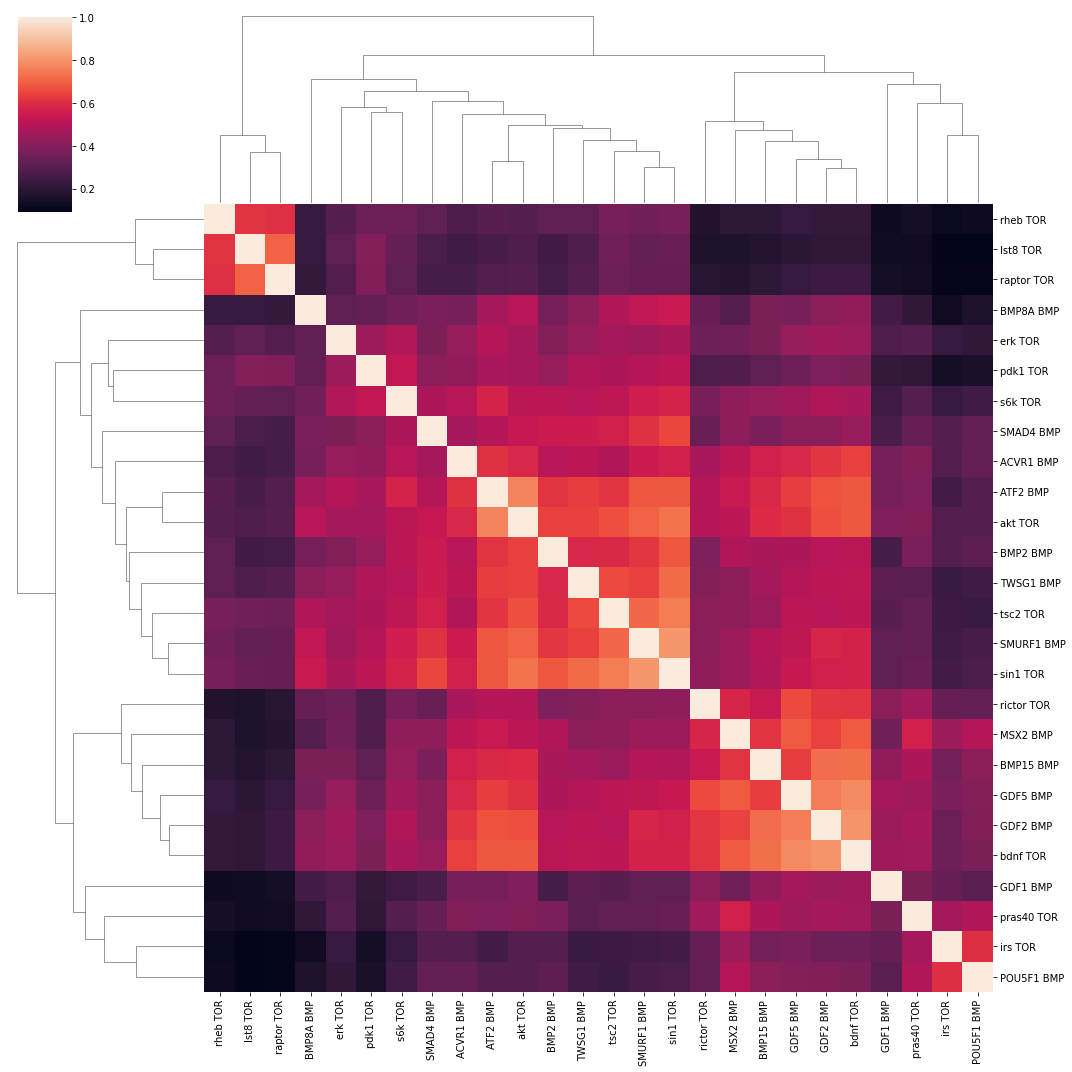

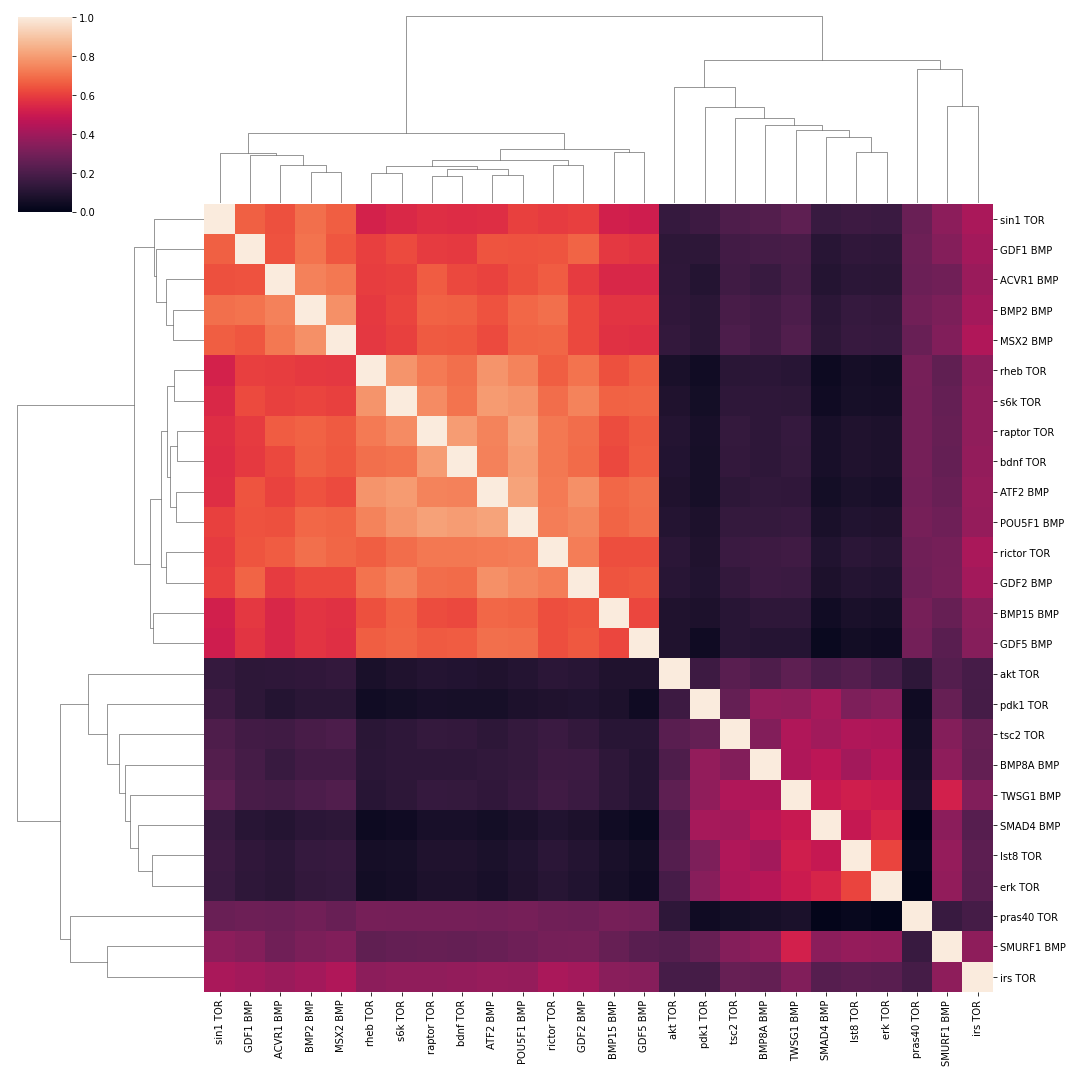

 do our matrices match from one approach to the other? 


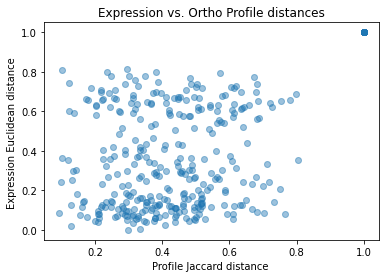

Pearson:PearsonRResult(statistic=0.3513750470253305, pvalue=4.4726841182644255e-21)
PIGXX
                                            anat           anatName  \
0  http://purl.obolibrary.org/obo/UBERON_0000007    pituitary gland   
1  http://purl.obolibrary.org/obo/UBERON_0000029         lymph node   
2  http://purl.obolibrary.org/obo/UBERON_0000451  prefrontal cortex   
3  http://purl.obolibrary.org/obo/UBERON_0000451  prefrontal cortex   
4  http://purl.obolibrary.org/obo/UBERON_0000473             testis   

              geneEns species canonicalid     names  
0  ENSSSCG00000013333   PIGXX      P14082  bdnf TOR  
1  ENSSSCG00000013333   PIGXX      P14082  bdnf TOR  
2  ENSSSCG00000010375   PIGXX  A0A4X1VFX4  GDF2 BMP  
3  ENSSSCG00000013333   PIGXX      P14082  bdnf TOR  
4  ENSSSCG00000013333   PIGXX      P14082  bdnf TOR  


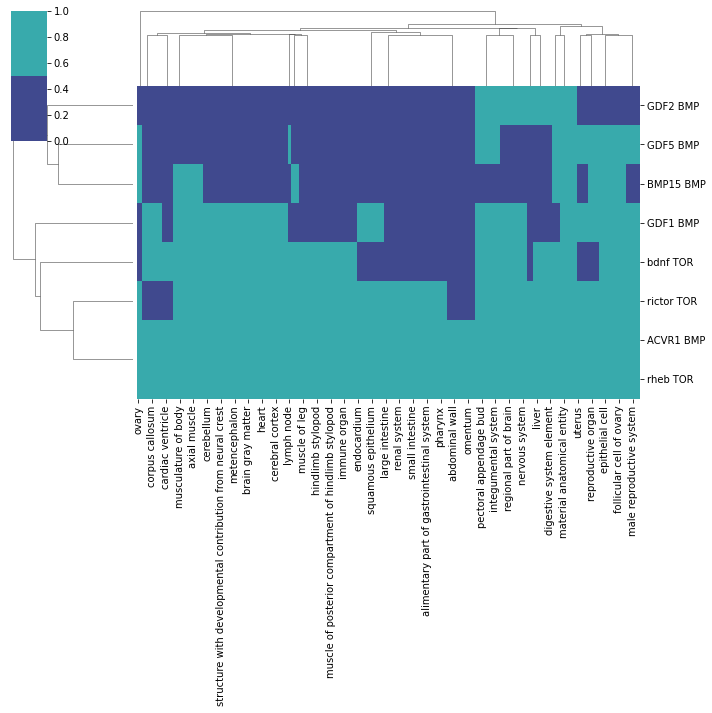

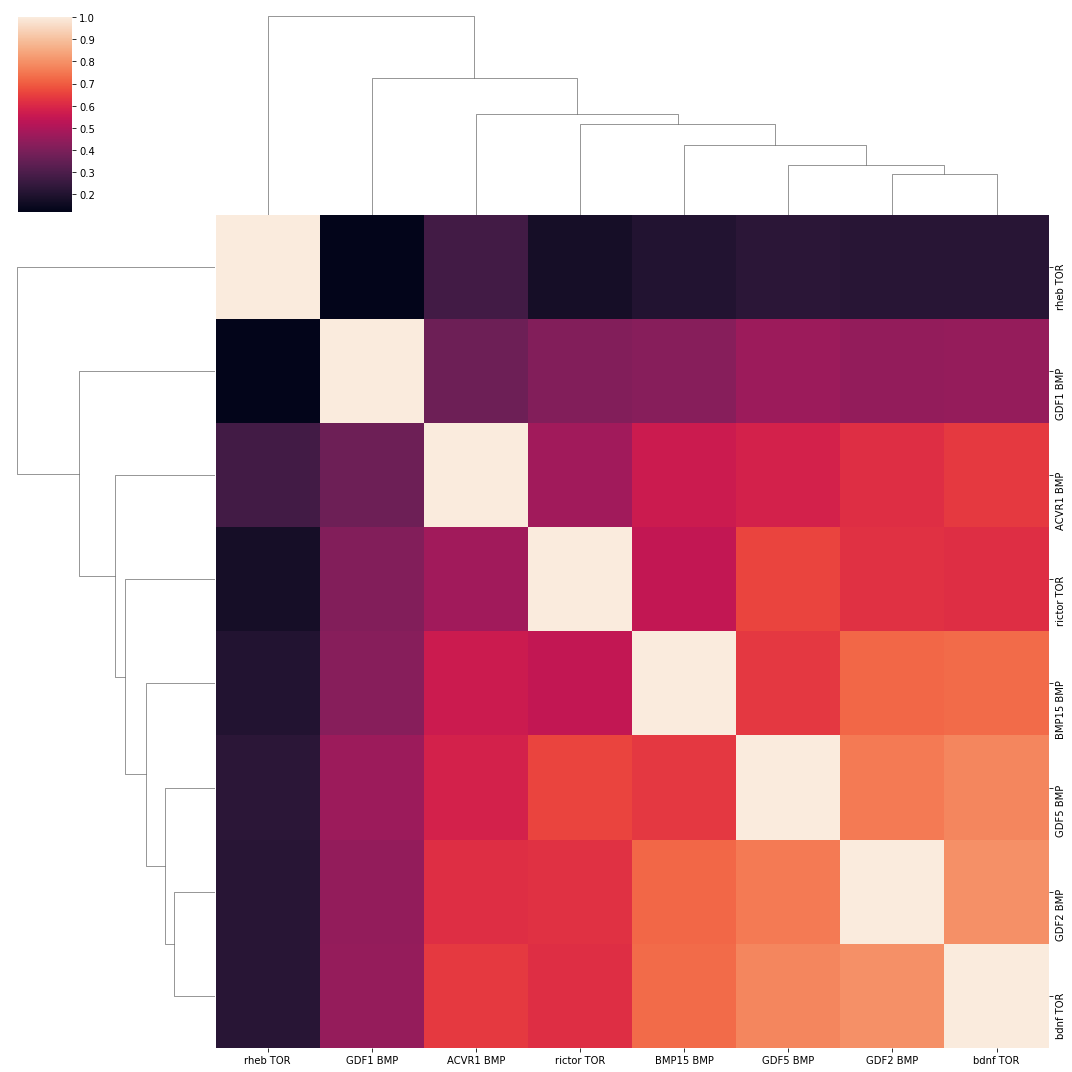

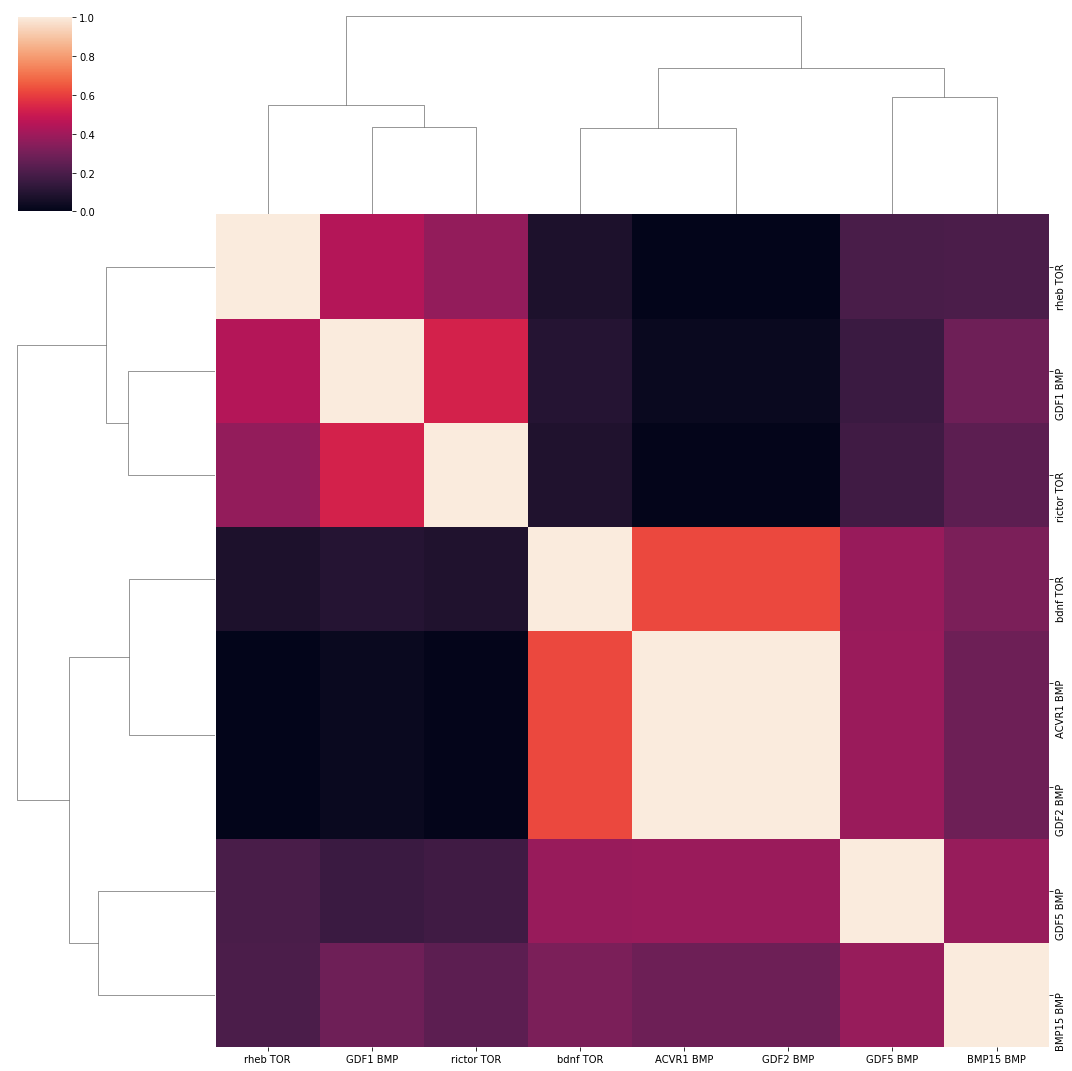

 do our matrices match from one approach to the other? 


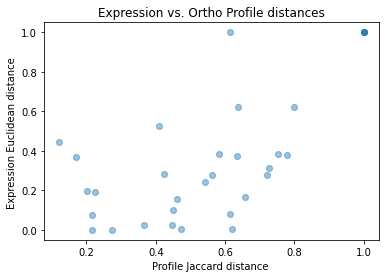

Pearson:PearsonRResult(statistic=0.6713567458596031, pvalue=1.2668638373332576e-09)


In [124]:
#now for the results of our efforts!
from scipy.stats import pearsonr , spearmanr


expression_mats = {}
expression_rowmappers = {}

for spec in expressionDF.species.unique():
    selected = set()
    #look at the clustering of the expression data for each species
    print(spec)
    sub = expressionDF[expressionDF.species == spec]
    #we can create another dataframe which shows the genes expressed in each tissue
    print(sub.head())
    #each row is a gene
    #each column is a tissue
    #we only consider tissues where at least one of the genes is expressed
    rows = list(sub.names.unique())
    columns = list(sub.anatName.unique())
    expr_mat = {r :{ c : 0 for c in columns  } for r in rows }
    #lets set all of the places where each gene is expressed to 1
    for i,r in sub.iterrows():
        selected.add(r.names)
        expr_mat[r.names][r.anatName] = 1
    
    selected = list(selected)
    #and transform everything into a dataframe
    expr_mat = pd.DataFrame.from_dict( expr_mat , orient='index' )
    
    #generate a clustered heatmap figure
    #to show similarity in expression patterns across tissues
    try:
        
        g = sns.clustermap( expr_mat , metric= metrics[0] , method=methods[2]  , col_cluster=True, row_cluster= True , cmap = sns.color_palette("mako", 2))
        #g.fig.suptitle(spec)
        g.savefig( spec+'expcluster.svg')
        plt.show()

        #comparing the phylogenetic profile distmat
        sub_orthodf = orthosdf.loc[selected]
        distmat_ortho = cdist(sub_orthodf.to_numpy(), sub_orthodf.to_numpy() , metric = metrics[2])
        g = sns.clustermap( 1-distmat_ortho , metric= metrics[0] , method=methods[1] , rasterized=True, col_cluster=True, row_cluster= True, yticklabels = selected , xticklabels = selected , figsize = (15, 15)  )
        #g.fig.suptitle( 'coevolution distmat' + spec) 
        plt.show()

        #with the expression profile distmat
        distmat_expr = cdist(expr_mat.to_numpy(), expr_mat.to_numpy() , metric = metrics[0])
        #scale the distmat
        distmat_expr /= np.amax(distmat_expr)

        g = sns.clustermap( 1-distmat_expr , metric= metrics[0] , method=methods[1] , col_cluster=True, rasterized=True,  row_cluster= True, yticklabels = selected, xticklabels =selected , figsize = (15, 15) )

        #g.fig.title( 'expression distmat' + spec ) 
        plt.show()

        expression_mats[spec] = 1-distmat_expr
        expression_rowmappers[spec] = selected

        #verify if expression and phylogenetic profile distances are correlated.
        print( ' do our matrices match from one approach to the other? ')
        plt.title( 'Expression vs. Ortho Profile distances')
        plt.xlabel( 'Profile Jaccard distance ')
        plt.ylabel( 'Expression Euclidean distance ')
        plt.scatter(1-distmat_ortho.ravel() , 1-distmat_expr.ravel() , alpha= .25)
        plt.savefig('expression_phylo_correlation_' + spec +'.png'  )
        plt.show()

        print( 'Pearson:'+ str( pearsonr( 1-distmat_ortho.ravel() , 1-distmat_expr.ravel() )  ) ) 
    except:
        pass

In [104]:
#pretty good matches in the cases where there is good resolution in the tissues
#It looks like there is coevolution and coexpression signal within each network
#now we can compare the networks generated with each approach to string.
#mtor and bmp are well studied pathways so they should have experimental
#and literature evidence in their String data

In [105]:
#we can add the interaction partners of the known network
#here we just hardcode known interactions so we can compare our 
#reconstructions.
#Thes interactions are from a review article describing the TOR
#pathway. Here we just hardcode them but we can also load some 
#data into networkx so long as the protein names don't change

from itertools import combinations
#these are fully connected cliques corresponding to heteromeric complexes
cliques = [ ['mtor','raptor' , 'lst8','pras40'] , ['tsc1', 'tsc2', 'lst8', 'rictor' , 'sin1' ]]
#here we add some individual connections
pairs =[
    ('cpkc' , 'irs'),
    ('irs' , 'p13k'),
    ('bdnf' , 'p13k'),
    ('ndmar' , 'p13k'),
    ('mglur' , 'p13k'),
    ('akt' , 'tsc1'),
    ('akt' , 'tsc2'),
    ('akt', 'pras40'),
    ('p13k' , 'pdk1'),
    ('pdk1' , 'cpkc'),
    ('pdk1' , 's6k'),
    ('erk' , 's6k'),
    ('rheb' , 'mtor'),
    ('akt' , 'mtor'),
    ('s6k' , 'mtor'),
    ('protor' , 'rictor'),
    ('pdk1' , 's6k'),
]

pairs += [ (p1,p2) for cl in cliques for p1,p2 in combinations(cl,2) ]
baseline_graph = nx.Graph()
baseline_graph.add_edges_from(pairs)
#we'll just set all the weights to .5 for visualization...
weights = {  e:{ 'key':'baseline', 'weight':.5} for e in baseline_graph.edges }
nx.set_edge_attributes(baseline_graph,  weights)
print(baseline_graph)
#now we have our 'baseline truth' graph

Graph with 20 nodes and 32 edges


In [106]:
#here are some function adapted from the string api reference https://string-db.org/help/api/
#we can map to string identifiers and pull down pairwise interactions for our genes across species

import requests
from time import sleep
from io import StringIO

string_api_url = "https://version-11-5.string-db.org/api"
def map2string(my_genes, species):
    output_format = "tsv-no-header"
    method = "get_string_ids"
    params = {
        "identifiers" : "\r".join(my_genes), # your protein list
        "species" : species , # species NCBI identifier 
        "limit" : 1, # only one (best) identifier per input protein
        "echo_query" : 1, # see your input identifiers in the output
        "caller_identity" :  "OMA profiling ipython notebook"  # your app name
    }
    request_url = "/".join([string_api_url, output_format, method])
    results = requests.post(request_url, data=params)
    mapper = {}
    for line in results.text.strip().split("\n"):
        l = line.split("\t")
        input_identifier, string_identifier = l[0], l[2]
        #print("Input:", input_identifier, "STRING:", string_identifier, sep="\t")
        mapper[string_identifier]= input_identifier
    return mapper

def get_string_net(my_genes , species, output_format = 'tsv'):
    sleep(1)
    method = "network"    
    request_url = "/".join([string_api_url, output_format, method])
    params = {
        "identifiers" : "%0d".join(my_genes), # your protein
        "species" : species, # species NCBI identifier 

        "caller_identity" : "OMA profiling ipython notebook" # your app name
    }
    response = requests.post(request_url, data=params).text
    return pd.read_table(StringIO(response))


HUMAN {'ACVR1_HUMAN': 'ENSG00000115170', 'BMP2_HUMAN': 'ENSG00000125845', 'GDF1_HUMAN': 'ENSG00000130283', 'TGBR3_HUMAN': 'ENSG00000069702', 'PO5F1_HUMAN': 'ENSG00000204531', 'SMUF1_HUMAN': 'ENSG00000198742', 'BMP15_HUMAN': 'ENSG00000130385', 'GDF2_HUMAN': 'ENSG00000263761', 'BMP8A_HUMAN': 'ENSG00000183682', 'MSX2_HUMAN': 'ENSG00000120149', 'TWSG1_HUMAN': 'ENSG00000128791', 'GDF5_HUMAN': 'ENSG00000125965', 'SMAD4_HUMAN': 'ENSG00000141646', 'USP9Y_HUMAN': 'ENSG00000114374', 'ATF2_HUMAN': 'ENSG00000115966'}
Graph with 13 nodes and 30 edges


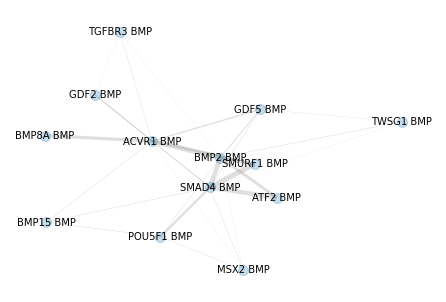

DROME {'A0A0B4KFU5': 'FBgn0029006', 'P27091': 'FBgn0024234', 'D3PFG0': 'FBgn0003865', 'Q9W494': 'FBgn0000394', 'Q8IMG6': 'FBgn0011655', 'M9PD17': 'FBgn0005198', 'Q9VND8': 'FBgn0041191', 'Q9W437': 'FBgn0029840', 'B4F5L6': 'FBgn0264691', 'M9PH06': 'FBgn0010303', 'Q9W0V1': 'FBgn0020386', 'Q9V719': 'FBgn0033935'}
Graph with 8 nodes and 15 edges


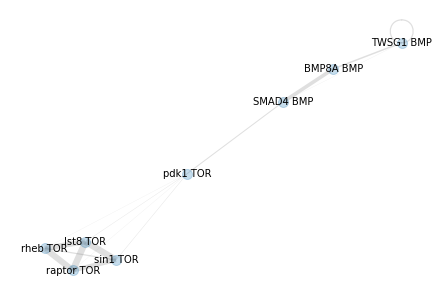

CAEEL {'P34443': 'WBGene00010038', 'P91040': 'WBGene00015697', 'A0A2K5ATN2': 'WBGene00008311', 'Q21307': 'WBGene00003185', 'Q9Y1J3': 'WBGene00003965'}
Graph with 3 nodes and 3 edges


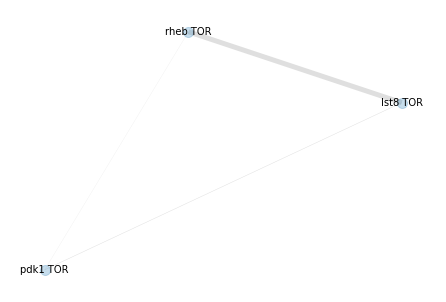

DANRE {'O13109': 'ENSDARG00000013409', 'E7FDB6': 'ENSDARG00000099979', 'Q6PCR3': 'ENSDARG00000016086', 'Q58FS4': 'ENSDARG00000037491', 'F1QWZ4': 'ENSDARG00000059173', 'Q1LWW7': 'ENSDARG00000035677', 'A0A0J9YJ71': 'ENSDARG00000104651', 'B2GR89': 'ENSDARG00000104244', 'F1QK08': 'ENSDARG00000002760', 'E9QBP5': 'ENSDARG00000023903', 'E7FA90': 'ENSDARG00000090194', 'F1Q5K0': 'ENSDARG00000018817', 'E9QC96': 'ENSDARG00000075156', 'A0A0R4IPN3': 'ENSDARG00000003167', 'E7FE05': 'ENSDARG00000060551', 'F6P5Q1': 'ENSDARG00000008279', 'Q6NZV1': 'ENSDARG00000018285', 'X1WFQ8': 'ENSDARG00000062304', 'X1WHT7': 'ENSDARG00000075977', 'E9QIJ2': 'ENSDARG00000091777'}
Graph with 8 nodes and 7 edges


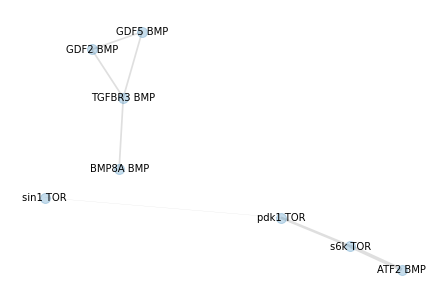

MOUSE {'B1AW87': 'ENSMUSG00000026836', 'Q3V1I4': 'ENSMUSG00000027358', 'P20863': 'ENSMUSG00000087408', 'P20263': 'ENSMUSG00000024406', 'E9PYU8': 'ENSMUSG00000038780', 'Q9Z0L4': 'ENSMUSG00000023279', 'Q9WV56': 'ENSMUSG00000072625', 'Q3TZB2': 'ENSMUSG00000032726', 'G3DRA8': 'ENSMUSG00000021469', 'Q9EP52': 'ENSMUSG00000024098', 'P43027': 'ENSMUSG00000038259', 'P97471': 'ENSMUSG00000024515', 'G3UXC3': 'ENSMUSG00000027104', 'B9EK93': 'ENSMUSG00000054667', 'P21237': 'ENSMUSG00000048482', 'Q7TT21': 'ENSMUSG00000002496', 'E0CX53': 'ENSMUSG00000033083', 'Q540E6': 'ENSMUSG00000028945', 'A4FUW1': 'ENSMUSG00000025583', 'Q9DCJ1': 'ENSMUSG00000024142', 'A0A140LJJ3': 'ENSMUSG00000011096', 'Q8C050': 'ENSMUSG00000021180', 'Q8CE90': 'ENSMUSG00000002948', 'F2Z3V6': 'ENSMUSG00000024122', 'Q812A5': 'ENSMUSG00000036106', 'A0A0A6YW60': 'ENSMUSG00000038696'}
Graph with 20 nodes and 39 edges


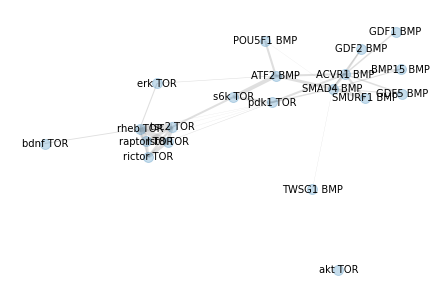

PIGXX {'A0A4X1VK14': 'ENSSSCG00000015874', 'F1S7D5': 'ENSSSCG00000013928', 'Q8WMY6': 'ENSSSCG00000012310', 'A0A4X1VFX4': 'ENSSSCG00000010375', 'F1S4W8': 'ENSSSCG00000023261', 'P14082': 'ENSSSCG00000013333', 'A0A4X1UNU1': 'ENSSSCG00000016434', 'A0A4X1W3B7': 'ENSSSCG00000021748'}
Graph with 0 nodes and 0 edges


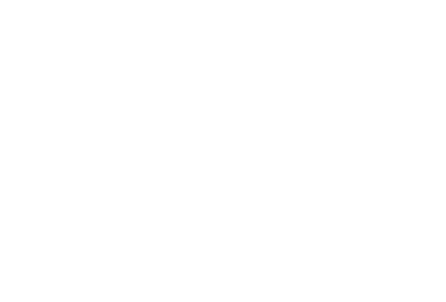

In [107]:
import networkx as nx
#Lets zoom in on the TOR pathway for this final step and compare our coexpression and coevolution
#graphs to the interactions found in databases, interaction experiments and the literature
#next get interaction net from string for each species so we can compare with our profile and expression based net
string_graphs = {}
for spec in qlists:
    print(spec, qlists[spec])
    #get string IDs for each protein
    mapper = map2string(qlists[spec], taxmap[spec] )
    rowmapper = {ID:i for i,ID in enumerate(mapper)}
    #make the string net using experimental evidence
    netdf = get_string_net(qlists[spec], taxmap[spec])
    netdf['x'] = netdf.stringId_A.map(rowmapper)
    netdf['y'] = netdf.stringId_B.map(rowmapper)
    netdf['Uniprot_A'] = netdf.stringId_A.map(mapper)
    netdf['Uniprot_B'] = netdf.stringId_B.map(mapper)
    netdf['name_A'] = netdf.Uniprot_A.map(names)
    netdf['name_B'] = netdf.Uniprot_B.map(names)
    
    
    #lets grab a network for each of our species of interest based on experimental data
    #we can remove the phylogenetic co-occurence channel from the evidence for a more independent verification
    #we can add the other evidence channels
    netdf['graphscore'] = ( netdf.ascore + netdf.escore + netdf.dscore ) / 3
    #transform the string net to networkx
    G = nx.Graph()
    [ G.add_edge( row.name_A , row.name_B  , weight=row.graphscore , key = 'string' ) for idx,row in netdf.iterrows() ]
    
    print(G)
    weights = np.asarray([e[2]['weight'] for e in G.edges(data = True)])
    weights/=3
    #max weight is 3 but we're scaling things from 0 to 1 to compare with our phylogenetic profiles
    pos = nx.spring_layout( G , weight='weight')
    
    nx.draw(G, pos=pos, edge_color='grey', width= 30*weights , node_size= 100 ,alpha = .25 ) 
    labels=nx.draw_networkx_labels(G , pos = pos , font_size= 10 )
    plt.show()
    string_graphs[spec] = G

orthograph
HUMAN
[]
0


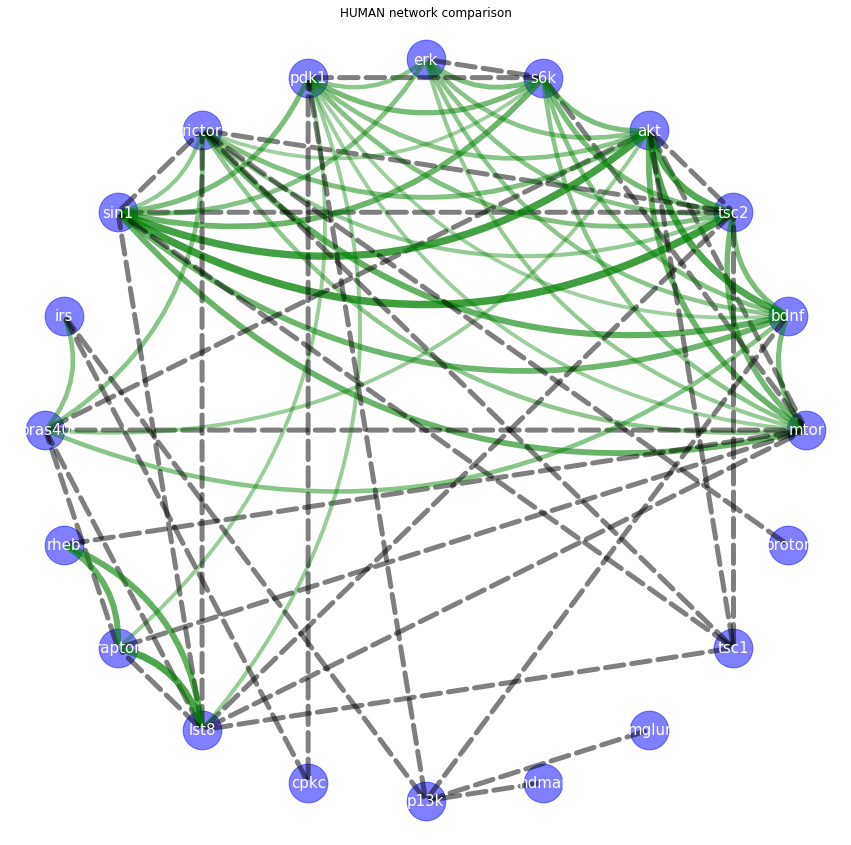

DROME
['lst8 TOR', 'pdk1 TOR', 'rheb TOR', 'raptor TOR', 'sin1 TOR']
10


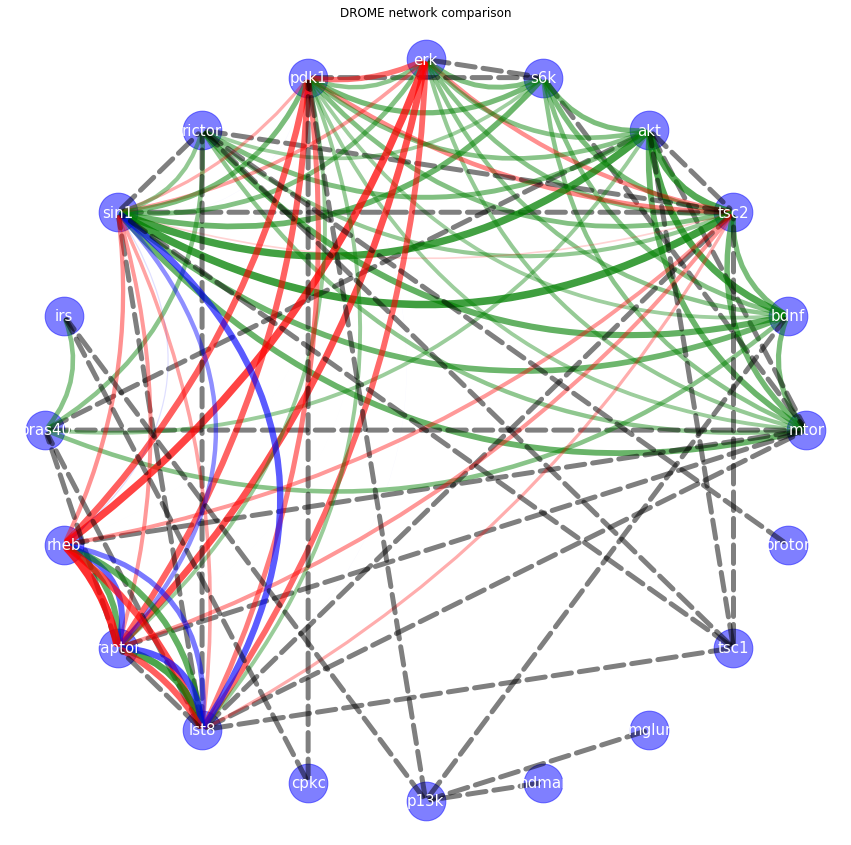

CAEEL
['lst8 TOR', 'pdk1 TOR', 'rheb TOR']
3


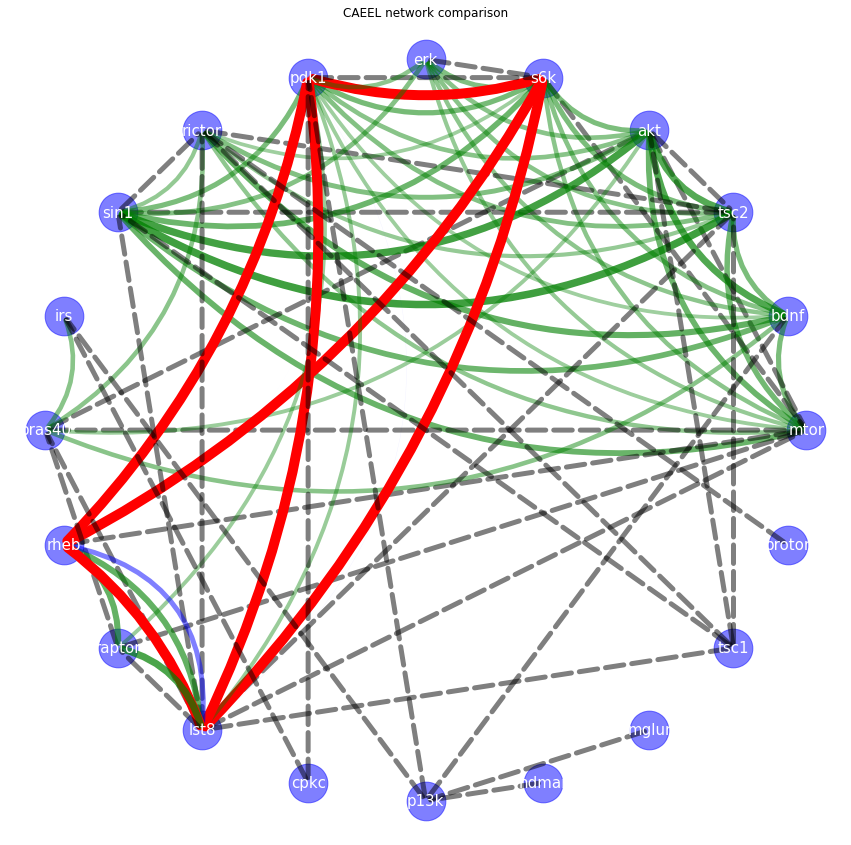

DANRE
['pdk1 TOR', 'sin1 TOR', 's6k TOR']
2


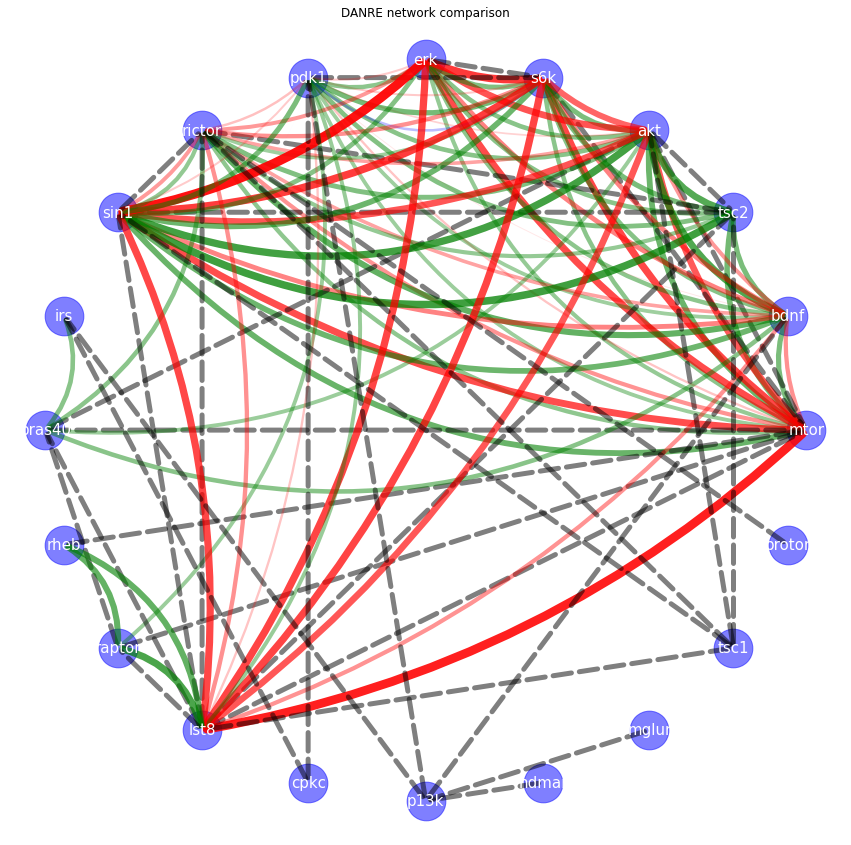

MOUSE
['erk TOR', 'rheb TOR', 'bdnf TOR', 'pdk1 TOR', 'raptor TOR', 'rictor TOR', 'tsc2 TOR', 'lst8 TOR', 's6k TOR', 'akt TOR']
19


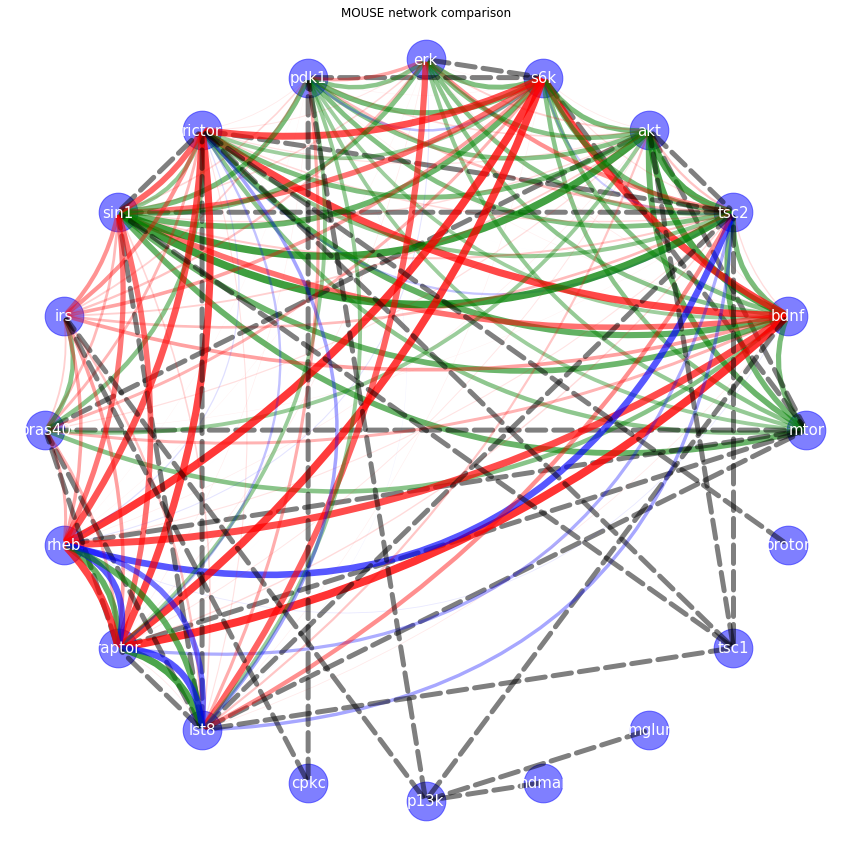

PIGXX
[]
0


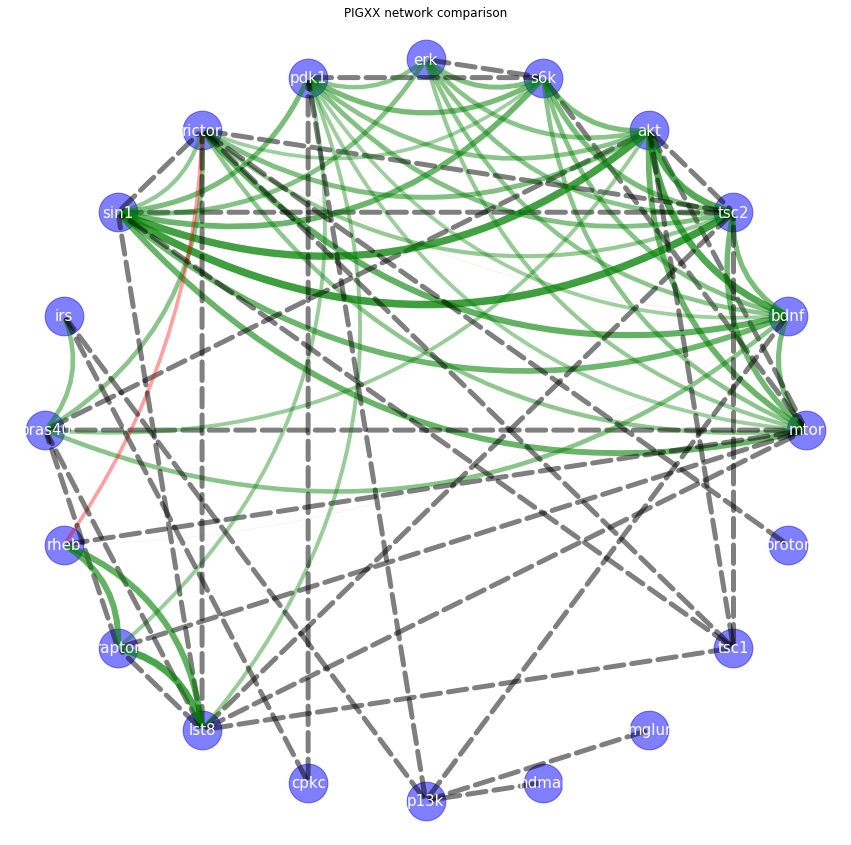

In [111]:
#now lets compare the overlap between the graphs
#we have string, phylogenetic profiling and expression based inference
#we also have our a priori knowledge based 'baseline' graph

#each method will get its own color. 
#hopefully we see some agreement between all 3
#the phylogenetic profile and baseline graphs wont change between species
#the other 2 will change

from matplotlib.pyplot import figure
colors = {'expre': 'r', 'ortho':'g', 'string':'b' , 'baseline':'black'}
curve = {'expre': 0.5, 'ortho':1, 'string':1.5 , 'baseline': 0 }
line_style = {'expre': '-', 'ortho':'-', 'string':'-' , 'baseline': '--' }

k = 100
print('orthograph')
#let's start by selecting our tor pathway genes and making an interation graph
#based on their jaccard scores
select = orthosdf.index.map( lambda x : 'TOR' in x )
tor_orthodf = orthosdf[select]
distmat_ortho = 1-cdist(tor_orthodf.to_numpy(), tor_orthodf.to_numpy() , metric = 'jaccard')
distmat_ortho /= np.amax(distmat_ortho)

#thresh to the top k hits
distmat_ortho[ distmat_ortho < np.partition(distmat_ortho.flatten(), -k)[-k] ] = 0
pandas_adj = pd.DataFrame(distmat_ortho)
pandas_adj.index = tor_orthodf.index
pandas_adj.columns = tor_orthodf.index
ortho_graph = nx.from_pandas_adjacency(pandas_adj)
weights = {  e:{ 'key':'ortho', 'weight':pandas_adj[e[0]][e[1]]} for e in ortho_graph.edges }
nx.set_edge_attributes(ortho_graph,  weights)

for spec in qlists:

    print(spec)
    #we can show all the graphs simultaneously in a multigraph
    #each edge set has a key
    G=nx.MultiGraph()
    
    #add phylo profiling graph
    G.add_edges_from(ortho_graph.edges(data=True))    
    #add string graph
    String_graph = string_graphs[spec]
    print(String_graph.nodes)
    exclude = [ n for n in String_graph.nodes if 'TOR' not in n ]
    String_graph.remove_nodes_from(exclude)
    print(len(String_graph.edges))
    G.add_edges_from( String_graph.edges(data = True ) )
    # and finally add the expression graph
    expr_mat = expression_mats[spec]
    
    try:
        #expr_mat[ expr_mat <  np.partition(expr_mat.flatten(), -k)[-k] ] = 0 
        pass
    except:
        #not enoguh data
        pass
    
    
    pandas_adj = pd.DataFrame(expr_mat)
    pandas_adj.index = expression_rowmappers[spec]
    pandas_adj.columns = expression_rowmappers[spec]
    select = [ n for n in pandas_adj.index if 'TOR' not in n]
    pandas_adj= pandas_adj.drop(select , axis = 0 )
    pandas_adj= pandas_adj.drop(select , axis = 1 )
    expression_graph = nx.from_pandas_adjacency(pandas_adj)
    weights = {  e:{ 'key':'expre' , 'weight':pandas_adj[e[0]][e[1]] } for e in expression_graph.edges }
    nx.set_edge_attributes(expression_graph,  weights)
    G.add_edges_from(expression_graph.edges(data = True))

    #lets remove the pathway label
    mapping = { n:n.replace('TOR','').strip() for n in G.nodes }
    G = nx.relabel_nodes(G, mapping)
    
    #and add the baseline graph
    G.add_edges_from(baseline_graph.edges(data = True))
    
    
    pos = nx.circular_layout( G )

    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(15)
    plt.plot()

    #plot the whole mess
    ax = plt.gca()
    
    for e in G.edges(data = True):
        ax.annotate("",
                    xy=pos[e[0]], xycoords='data',
                    xytext=pos[e[1]], textcoords='data',
                    arrowprops=dict(arrowstyle="-", color=colors[e[2]['key']],
                                    shrinkA=5, shrinkB=5, lw = 10*e[2]['weight'], ls = line_style[e[2]['key']],
                                    patchA=None, patchB=None, alpha = e[2]['weight'],
                                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*curve[e[2]['key']])
                                    ),
                                    ),
                    )
        
    nx.draw_networkx_nodes(G, pos, node_color = 'b', node_size = 1500, alpha = .5)

    labels=nx.draw_networkx_labels(G , pos = pos , font_size= 15 , font_color='w')
    
    plt.axis('off')
    plt.title(spec + ' network comparison')
    plt.show()